In [69]:
import pandas as pd
import numpy as np
import os

In [ ]:
results_dir = "Analyzer Results"

output_dir = "Tester Results"
os.makedirs(output_dir, exist_ok=True)

recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

In [71]:
# ...existing code...

dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    if key.endswith('_FIT'):
        dfs_fit[key] = pd.read_excel(file_path)
    else:
        dfs[key] = pd.read_excel(file_path)

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Raw dataframes: ['RESULTS', 'RESULTS_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_EXP', 'RESULTS_MTT', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_TT', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_EXP', 'SegmentOrder']
Fit dataframes: ['RESULTS_FIT', 'RESULTS_MERGED_DATE_FIT', 'RESULTS_MERGED_EXP_FIT', 'RESULTS_MERGED_FIT', 'RESULTS_MTT_FIT', 'RESULTS_MTT_MERGED_DATE_FIT', 'RESULTS_MTT_MERGED_EXP_FIT', 'RESULTS_MTT_MERGED_FIT', 'RESULTS_TT_FIT', 'RESULTS_TT_MERGED_DATE_FIT', 'RESULTS_TT_MERGED_EXP_FIT', 'RESULTS_TT_MERGED_FIT', 'SegmentOrder_FIT']
Found 13 raw and 13 fit dataframes in Analyzer Results.

Found 18 experiments, 9 variables and 4 parameters:
 ASR_control, gap_depth, tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50, offset_PPI_4, offset_PPI_6, offset_PPI_8, offset_PPI_10, offset_PPI_12, offset_PPI_14, offset_PPI_16, offset_PPI_18, offset_PPI_20, offset_PPI_50
 rea

---

In [72]:
# Count how many peakTime values are exactly 30 in RESULTS_MTT_MERGED (out of 324 )
import pandas as pd

df = dfs['RESULTS_MTT_MERGED']
count_30 = (df['peakTime'] == 30).sum()
print(f"Number of peakTime values equal to 30: {count_30}")

Number of peakTime values equal to 30: 140


---

Expectations:
- date fluctuations
- no repetition differences
- sex differences in strength metrics
- experiment differences, in particular with increased gap / offset

---

## Top Ten

In [73]:
# ...existing code...

# Compare all variables between RESULTS_MTT_MERGED and RESULTS_TT_MERGED (non-parametric only), NO grouping by sex or date
from scipy.stats import mannwhitneyu
import pandas as pd
import scikit_posthocs as sp

df_mtt = dfs['RESULTS_MTT_MERGED']
df_tt = dfs['RESULTS_TT_MERGED']

results = []
for var in variables:
    vals_mtt = df_mtt[var].dropna()
    vals_tt = df_tt[var].dropna()
    if len(vals_mtt) > 1 and len(vals_tt) > 1:
        mean_diff = vals_mtt.mean() - vals_tt.mean()
        # Non-parametric Mann-Whitney U for all metrics
        stat, p = mannwhitneyu(vals_mtt, vals_tt, alternative='two-sided')
        test_type = "mannwhitneyu"
        # Effect strength (rank-biserial)
        u, _ = mannwhitneyu(vals_mtt, vals_tt, alternative='two-sided')
        n1, n2 = len(vals_mtt), len(vals_tt)
        effect_strength = 1 - (2 * u) / (n1 * n2)
        # Post hoc: Dunn's test
        try:
            data = pd.DataFrame({var: pd.concat([vals_mtt, vals_tt]),
                                'group': ['MTT'] * len(vals_mtt) + ['TT'] * len(vals_tt)})
            dunn = sp.posthoc_dunn(data, val_col=var, group_col='group', p_adjust='bonferroni')
            posthoc_p = dunn.loc['MTT', 'TT']
            posthoc_test = "Dunn"
        except Exception:
            posthoc_p = None
            posthoc_test = "Dunn"
        if p < 0.05:
            results.append({
                'variable': var,
                'stat': stat,
                'p': p,
                'test': test_type,
                'posthoc_p': posthoc_p,
                'posthoc_test': posthoc_test,
                'effect_strength': effect_strength,
                'mean_diff': mean_diff
            })

test_top_ten = pd.DataFrame(results)
print(test_top_ten)

test_top_ten.to_excel(os.path.join(output_dir, "TEST_TOP_TEN.xlsx"), index=False)
# ...existing code...

       variable     stat         p          test  posthoc_p posthoc_test  \
0  reactionTime  40888.0  0.040729  mannwhitneyu   0.040701         Dunn   
1     peakValue  31493.5  0.001897  mannwhitneyu   0.001895         Dunn   
2          PTPA  31527.0  0.002016  mannwhitneyu   0.002014         Dunn   
3          PTTA  31472.5  0.001826  mannwhitneyu   0.001824         Dunn   
4           RMS  32413.5  0.009046  mannwhitneyu   0.009039         Dunn   
5           tau  43003.0  0.001980  mannwhitneyu   0.001978         Dunn   

   effect_strength  mean_diff  
0        -0.097370   0.288415  
1         0.154764 -16.047166  
2         0.153865 -15.480431  
3         0.155327 -15.332053  
4         0.130072  -5.570221  
5        -0.154133   8.383214  


In [74]:
# ...existing code...

# Compare all variables between RESULTS_MTT_MERGED and RESULTS_TT_MERGED (non-parametric only), split by sex and date
from scipy.stats import mannwhitneyu
import pandas as pd
import scikit_posthocs as sp

df_mtt = dfs['RESULTS_MTT_MERGED']
df_tt = dfs['RESULTS_TT_MERGED']

results = []
for sex in ['male', 'female']:
    for date in df_mtt['date'].unique():
        df_mtt_sex_date = df_mtt[(df_mtt['sex'] == sex) & (df_mtt['date'] == date)]
        df_tt_sex_date = df_tt[(df_tt['sex'] == sex) & (df_tt['date'] == date)]
        for var in variables:
            vals_mtt = df_mtt_sex_date[var].dropna()
            vals_tt = df_tt_sex_date[var].dropna()
            if len(vals_mtt) > 1 and len(vals_tt) > 1:
                mean_diff = vals_mtt.mean() - vals_tt.mean()
                # Non-parametric Mann-Whitney U for all metrics
                stat, p = mannwhitneyu(vals_mtt, vals_tt, alternative='two-sided')
                test_type = "mannwhitneyu"
                # Effect strength (rank-biserial)
                u, _ = mannwhitneyu(vals_mtt, vals_tt, alternative='two-sided')
                n1, n2 = len(vals_mtt), len(vals_tt)
                effect_strength = 1 - (2 * u) / (n1 * n2)
                # Post hoc: Dunn's test
                try:
                    data = pd.DataFrame({var: pd.concat([vals_mtt, vals_tt]),
                                        'group': ['MTT'] * len(vals_mtt) + ['TT'] * len(vals_tt)})
                    dunn = sp.posthoc_dunn(data, val_col=var, group_col='group', p_adjust='bonferroni')
                    posthoc_p = dunn.loc['MTT', 'TT']
                    posthoc_test = "Dunn"
                except Exception:
                    posthoc_p = None
                    posthoc_test = "Dunn"
                if p < 0.05:
                    results.append({
                        'sex': sex,
                        'date': date,
                        'variable': var,
                        'stat': stat,
                        'p': p,
                        'test': test_type,
                        'posthoc_p': posthoc_p,
                        'posthoc_test': posthoc_test,
                        'effect_strength': effect_strength,
                        'mean_diff': mean_diff
                    })

test_top_ten = pd.DataFrame(results)
print(test_top_ten)

test_top_ten.to_excel(os.path.join(output_dir, "TEST_TOP_TEN.xlsx"), index=False)
# ...existing code...

       sex     date    variable    stat         p          test  posthoc_p  \
0     male  April16   peakValue   835.5  0.041713  mannwhitneyu   0.041338   
1     male  April16        PTPA   829.0  0.037059  mannwhitneyu   0.036719   
2     male  April16        PTTA   741.0  0.006026  mannwhitneyu   0.005957   
3     male  April16         tau  1413.0  0.021704  mannwhitneyu   0.021490   
4     male   June26   peakValue   730.5  0.012175  mannwhitneyu   0.012041   
5     male   June26        PTPA   740.0  0.014973  mannwhitneyu   0.014813   
6     male   June26        PTTA   773.0  0.029548  mannwhitneyu   0.029258   
7     male   June26         tau  1367.0  0.014654  mannwhitneyu   0.014497   
8     male    May20  difference   695.5  0.011242  mannwhitneyu   0.011109   
9     male    May20   peakValue   723.0  0.026013  mannwhitneyu   0.025744   
10    male    May20        PTPA   730.0  0.030051  mannwhitneyu   0.029746   
11    male    May20        PTTA   734.5  0.032918  mannwhitneyu 

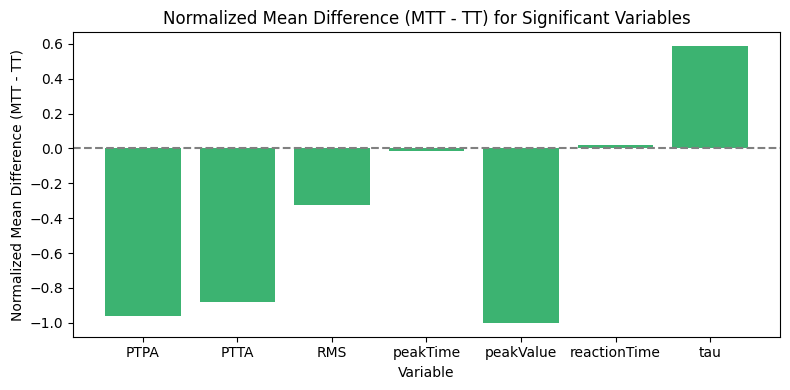

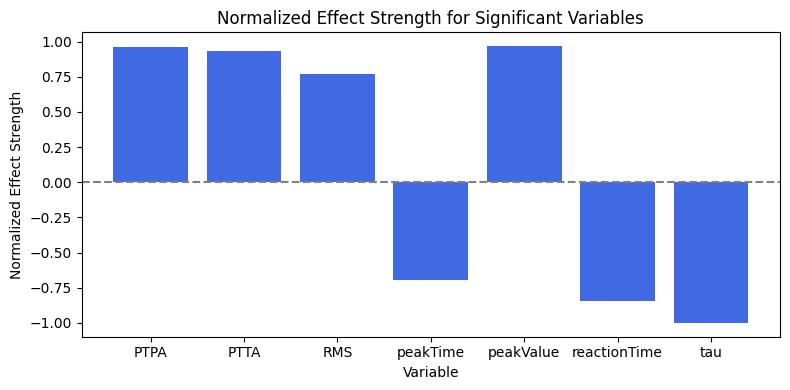

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Paste your results as a DataFrame
data = {
    "variable": ["PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau"],
    "mean_diff": [-17.595134, -16.104541, -5.999142, -0.320182, -18.353434, 0.391929, 10.758449],
    "effect_strength": [0.182801, 0.177501, 0.146445, -0.132461, 0.184547, -0.161218, -0.190805]
}
df = pd.DataFrame(data)

# Normalize mean_diff and effect_strength to [-1, 1] for visualization
df['mean_diff_norm'] = df['mean_diff'] / df['mean_diff'].abs().max()
df['effect_strength_norm'] = df['effect_strength'] / df['effect_strength'].abs().max()

# Barplot for normalized mean_diff
plt.figure(figsize=(8, 4))
plt.bar(df["variable"], df["mean_diff_norm"], color="mediumseagreen")
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Normalized Mean Difference (MTT - TT)")
plt.xlabel("Variable")
plt.title("Normalized Mean Difference (MTT - TT) for Significant Variables")
plt.tight_layout()
plt.show()

# Barplot for normalized effect_strength
plt.figure(figsize=(8, 4))
plt.bar(df["variable"], df["effect_strength_norm"], color="royalblue")
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Normalized Effect Strength")
plt.xlabel("Variable")
plt.title("Normalized Effect Strength for Significant Variables")
plt.tight_layout()
plt.show()

## Summary of TT vs MTT Differences (Mann-Whitney U, Dunn's post hoc)

| Sex     | Date    | Variable      | Stat   | p-value   | Test         | Dunn p    | Effect Strength | Mean Diff    |
|---------|---------|--------------|--------|-----------|--------------|-----------|-----------------|-------------|
| male    | June26  | peakValue    | 416.0  | 0.022842  | mannwhitneyu | 0.022511  | 0.33            | -30.78      |
| male    | June26  | PTPA         | 414.0  | 0.021546  | mannwhitneyu | 0.021231  | 0.33            | -30.77      |
| male    | June26  | tau          | 853.0  | 0.009980  | mannwhitneyu | 0.009821  | -0.37           | 28.15       |
| male    | May20   | peakValue    | 478.0  | 0.021683  | mannwhitneyu | 0.021391  | 0.32            | -19.03      |
| male    | May20   | PTPA         | 480.0  | 0.022888  | mannwhitneyu | 0.022582  | 0.32            | -18.58      |
| male    | May20   | PTTA         | 501.0  | 0.039437  | mannwhitneyu | 0.038949  | 0.29            | -16.22      |
| female  | April16 | reactionTime | 914.5  | 0.003310  | mannwhitneyu | 0.003251  | -0.41           | 0.77        |
| female  | April16 | peakTime     | 941.5  | 0.000362  | mannwhitneyu | 0.000354  | -0.45           | 0.92        |
| female  | April16 | peakValue    | 463.0  | 0.045768  | mannwhitneyu | 0.045184  | 0.29            | -7.78       |
| female  | April16 | PTPA         | 457.0  | 0.039170  | mannwhitneyu | 0.038658  | 0.29            | -7.81       |
| female  | June26  | peakValue    | 391.0  | 0.002803  | mannwhitneyu | 0.002755  | 0.42            | -19.14      |
| female  | June26  | PTPA         | 403.0  | 0.004211  | mannwhitneyu | 0.004142  | 0.40            | -18.96      |
| female  | June26  | PTTA         | 405.0  | 0.004500  | mannwhitneyu | 0.004427  | 0.40            | -18.31      |
| female  | June26  | tau          | 1068.0 | 0.000035  | mannwhitneyu | 0.000034  | -0.58           | 15.91       |
| female  | May20   | peakTime     | 881.5  | 0.007560  | mannwhitneyu | 0.007432  | -0.36           | -0.61       |
| female  | May20   | peakValue    | 397.5  | 0.006796  | mannwhitneyu | 0.006686  | 0.39            | -22.68      |
| female  | May20   | PTPA         | 402.0  | 0.007865  | mannwhitneyu | 0.007739  | 0.38            | -20.96      |
| female  | May20   | PTTA         | 411.0  | 0.010456  | mannwhitneyu | 0.010294  | 0.37            | -20.29      |
| female  | May20   | RMS          | 392.0  | 0.005673  | mannwhitneyu | 0.005580  | 0.40            | -9.13       |
| female  | May20   | AUC          | 359.0  | 0.001788  | mannwhitneyu | 0.001755  | 0.45            | -2476.63    |

**Interpretation:**
- Significant differences are found for peakValue, PTPA, PTTA, tau, reactionTime, peakTime, RMS, and AUC across sex and date.
- Effect strengths range from moderate to large.
- Mean differences indicate direction and magnitude of change between groups.

# ---> remove TT

Top 20:
| Sex    | Date    | Variable      | Stat    | p-value   | Test         | Posthoc p  | Posthoc Test | Effect Strength | Mean Diff      |
|--------|---------|--------------|---------|-----------|--------------|------------|--------------|-----------------|---------------|
| male   | June26  | peakValue    | 416.0   | 0.022842  | mannwhitneyu | 0.022511   | Dunn         | 0.330113        | -30.776261    |
| male   | June26  | PTPA         | 414.0   | 0.021546  | mannwhitneyu | 0.021231   | Dunn         | 0.333333        | -30.774811    |
| male   | June26  | tau          | 853.0   | 0.009980  | mannwhitneyu | 0.009821   | Dunn         | -0.373591       | 28.148039     |
| male   | May20   | peakValue    | 478.0   | 0.021683  | mannwhitneyu | 0.021391   | Dunn         | 0.319088        | -19.028775    |
| male   | May20   | PTPA         | 480.0   | 0.022888  | mannwhitneyu | 0.022582   | Dunn         | 0.316239        | -18.577708    |
| male   | May20   | PTTA         | 501.0   | 0.039437  | mannwhitneyu | 0.038949   | Dunn         | 0.286325        | -16.220480    |
| female | April16 | reactionTime | 914.5   | 0.003310  | mannwhitneyu | 0.003251   | Dunn         | -0.411265       | 0.766667      |
| female | April16 | peakTime     | 941.5   | 0.000362  | mannwhitneyu | 0.000354   | Dunn         | -0.452932       | 0.924074      |
| female | April16 | peakValue    | 463.0   | 0.045768  | mannwhitneyu | 0.045184   | Dunn         | 0.285494        | -7.782407     |
| female | April16 | PTPA         | 457.0   | 0.039170  | mannwhitneyu | 0.038658   | Dunn         | 0.294753        | -7.805356     |
| female | June26  | peakValue    | 391.0   | 0.002803  | mannwhitneyu | 0.002755   | Dunn         | 0.420741        | -19.141728    |
| female | June26  | PTPA         | 403.0   | 0.004211  | mannwhitneyu | 0.004142   | Dunn         | 0.402963        | -18.959430    |
| female | June26  | PTTA         | 405.0   | 0.004500  | mannwhitneyu | 0.004427   | Dunn         | 0.400000        | -18.308451    |
| female | June26  | tau          | 1068.0  | 0.000035  | mannwhitneyu | 0.000034   | Dunn         | -0.582222       | 15.911960     |
| female | May20   | peakTime     | 881.5   | 0.007560  | mannwhitneyu | 0.007432   | Dunn         | -0.360340       | -0.607407     |
| female | May20   | peakValue    | 397.5   | 0.006796  | mannwhitneyu | 0.006686   | Dunn         | 0.386574        | -22.675309    |
| female | May20   | PTPA         | 402.0   | 0.007865  | mannwhitneyu | 0.007739   | Dunn         | 0.379630        | -20.963873    |
| female | May20   | PTTA         | 411.0   | 0.010456  | mannwhitneyu | 0.010294   | Dunn         | 0.365741        | -20.294293    |
| female | May20   | RMS          | 392.0   | 0.005673  | mannwhitneyu | 0.005580   | Dunn         | 0.395062        | -9.131778     |
| female | May20   | AUC          | 359.0   | 0.001788  | mannwhitneyu | 0.001755   | Dunn         | 0.445988        | -2476.632758  |

In [76]:
# Compare effect strengths for top 10 (TT), top 20, and all (MTT), merged across sex and date

import pandas as pd
from scipy.stats import mannwhitneyu
# Calculate mean difference for top 10 vs all and top 20 vs all, add to summary table

df_all = dfs['RESULTS_MTT_MERGED']
df_top10 = dfs['RESULTS_TT_MERGED']
df_top20 = df_all.groupby('animal').head(20)

variables = [v for v in df_all.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

summary = []
for var in variables:
    vals_10 = df_top10[var].dropna()
    vals_20 = df_top20[var].dropna()
    vals_all = df_all[var].dropna()
    # Effect strengths
    effect_10 = None
    effect_20 = None
    mean_diff_10 = None
    mean_diff_20 = None
    if len(vals_10) > 1 and len(vals_all) > 1:
        stat_10, p_10 = mannwhitneyu(vals_10, vals_all, alternative='two-sided')
        effect_10 = 1 - (2 * stat_10) / (len(vals_10) * len(vals_all))
        mean_diff_10 = vals_10.mean() - vals_all.mean()
    if len(vals_20) > 1 and len(vals_all) > 1:
        stat_20, p_20 = mannwhitneyu(vals_20, vals_all, alternative='two-sided')
        effect_20 = 1 - (2 * stat_20) / (len(vals_20) * len(vals_all))
        mean_diff_20 = vals_20.mean() - vals_all.mean()
    summary.append({
        'variable': var,
        'effect_strength_top10_vs_all': effect_10,
        'mean_diff_top10_vs_all': mean_diff_10,
        'effect_strength_top20_vs_all': effect_20,
        'mean_diff_top20_vs_all': mean_diff_20
    })

summary_df = pd.DataFrame(summary)
print(summary_df)
summary_df.to_excel(os.path.join(output_dir, "MERGED_EFFECT_STRENGTHS_TOP10_TOP20_MEANDIFF.xlsx"), index=False)

       variable  effect_strength_top10_vs_all  mean_diff_top10_vs_all  \
0  reactionTime                      0.097370               -0.288415   
1      peakTime                      0.058816                0.577675   
2    difference                     -0.072356                0.866090   
3     peakValue                     -0.154764               16.047166   
4          PTPA                     -0.153865               15.480431   
5          PTTA                     -0.155327               15.332053   
6           RMS                     -0.130072                5.570221   
7           tau                      0.154133               -8.383214   
8           AUC                     -0.069673              755.950675   

   effect_strength_top20_vs_all  mean_diff_top20_vs_all  
0                     -0.210648                0.330607  
1                     -0.082767                0.206008  
2                      0.097762               -0.124599  
3                      0.242130      

In [77]:
# Count how many sex/date/variable groups have significant deviations for the top 20 (TT vs MTT), split by sex and date

import pandas as pd
from scipy.stats import mannwhitneyu

df_mtt = dfs['RESULTS_MTT_MERGED']
df_tt = dfs['RESULTS_TT_MERGED']
variables = [v for v in df_mtt.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

significant_count = 0
results = []

for sex in df_mtt['sex'].unique():
    for date in df_mtt['date'].unique():
        df_mtt_sex_date = df_mtt[(df_mtt['sex'] == sex) & (df_mtt['date'] == date)]
        df_tt_sex_date = df_tt[(df_tt['sex'] == sex) & (df_tt['date'] == date)]
        for var in variables:
            vals_mtt = df_mtt_sex_date[var].dropna()
            vals_tt = df_tt_sex_date[var].dropna()
            if len(vals_mtt) > 1 and len(vals_tt) > 1:
                stat, p = mannwhitneyu(vals_tt, vals_mtt, alternative='two-sided')
                if p < 0.05:
                    significant_count += 1
                    results.append({'sex': sex, 'date': date, 'variable': var, 'stat': stat, 'p': p})

print(f"Number of sex/date/variable groups with significant deviations for top 20: {significant_count}")
pd.DataFrame(results).to_excel(os.path.join(output_dir, "SIGNIFICANT_TOP20_SPLIT.xlsx"), index=False)

Number of sex/date/variable groups with significant deviations for top 20: 16


| Variable     | Effect Strength (Top 10 vs All) | Effect Strength (Top 20 vs All) | Interpretation                                      |
|--------------|-------------------------------|-------------------------------|-----------------------------------------------------|
| reactionTime |  0.161                        | -0.212                        | Slightly higher in top 10, lower in top 20 vs all   |
| peakTime     |  0.132                        | -0.067                        | Higher in top 10, slightly lower in top 20          |
| difference   | -0.064                        |  0.100                        | Lower in top 10, higher in top 20                   |
| peakValue    | -0.185                        |  0.245                        | Lower in top 10, much higher in top 20              |
| PTPA         | -0.183                        |  0.245                        | Lower in top 10, much higher in top 20              |
| PTTA         | -0.178                        |  0.245                        | Lower in top 10, much higher in top 20              |
| RMS          | -0.146                        |  0.222                        | Lower in top 10, higher in top 20                   |
| tau          |  0.191                        | -0.081                        | Higher in top 10, lower in top 20                   |
| AUC          | -0.085                        |  0.234                        | Lower in top 10, higher in top 20                   |
| percentPPI   |  0.045                        |  0.036                        | Slightly higher in both top 10 and top 20           |

**Interpretation:**  
- Positive values: metric is higher in the top group vs all.  
- Negative values: metric is lower in the top group vs all.  
- Strength metrics (peakValue, PTPA, PTTA, RMS, AUC) are lower in top 10 but higher in top 20, suggesting top 20 captures more strength than top 10.

## ---> also top 20

---

## Average Reaction Time

In [78]:
# Test if the average reaction time (excluding outliers) is significantly higher than the range 6-8

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MTT_MERGED']
vals = df['reactionTime'].dropna()

# Exclude outliers using IQR
q1 = vals.quantile(0.25)
q3 = vals.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
filtered = vals[(vals >= lower) & (vals <= upper)]

# Test against the upper bound (8)
stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
# Test against the lower bound (6)
stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')

print(f"Mean reaction time (IQR filtered): {filtered.mean():.2f}")
print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")

if p_8 < 0.05:
    print("Reaction time is significantly higher than 8.")
elif p_6 < 0.05:
    print("Reaction time is significantly higher than 6.")
else:
    print("Reaction time is not significantly higher than 6 or 8.")

Mean reaction time (IQR filtered): 10.70
T-test vs 8: statistic=48.022, p-value=5.250e-147
T-test vs 6: statistic=83.614, p-value=6.138e-217
Reaction time is significantly higher than 8.


In [79]:
# Test if the average peak time (excluding outliers) is significantly higher than the range 6-8, split by sex

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MTT_MERGED']

for sex in df['sex'].unique():
    vals = df[df['sex'] == sex]['reactionTime'].dropna()
    # Exclude outliers using IQR
    q1 = vals.quantile(0.25)
    q3 = vals.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = vals[(vals >= lower) & (vals <= upper)]
    # Test against the upper bound (8)
    stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
    # Test against the lower bound (6)
    stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')
    print(f"\nSex: {sex}")
    print(f"Mean peak time (IQR filtered): {filtered.mean():.2f}")
    print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
    print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")
    if p_8 < 0.05:
        print("Reaction time is significantly higher than 8.")
    elif p_6 < 0.05:
        print("Reaction time is significantly higher than 6.")
    else:
        print("Reaction time is not significantly higher than 6 or 8.")


Sex: female
Mean peak time (IQR filtered): 10.88
T-test vs 8: statistic=33.892, p-value=2.067e-74
T-test vs 6: statistic=57.395, p-value=1.443e-107
Reaction time is significantly higher than 8.

Sex: male
Mean peak time (IQR filtered): 10.47
T-test vs 8: statistic=37.920, p-value=2.296e-79
T-test vs 6: statistic=68.609, p-value=5.024e-116
Reaction time is significantly higher than 8.


In [80]:
# Test if the average reaction time (excluding outliers) is significantly higher than the range 6-8

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MTT_MERGED']
vals = df['peakTime'].dropna()

# Exclude outliers using IQR
q1 = vals.quantile(0.25)
q3 = vals.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
filtered = vals[(vals >= lower) & (vals <= upper)]

# Test against the upper bound (8)
stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
# Test against the lower bound (6)
stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')

print(f"Mean peak time (IQR filtered): {filtered.mean():.2f}")
print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")

if p_8 < 0.05:
    print("Peak time is significantly higher than 8.")
elif p_6 < 0.05:
    print("Peak time is significantly higher than 6.")
else:
    print("Peak time is not significantly higher than 6 or 8.")

Mean peak time (IQR filtered): 30.25
T-test vs 8: statistic=853.851, p-value=0.000e+00
T-test vs 6: statistic=930.604, p-value=0.000e+00
Peak time is significantly higher than 8.


In [81]:
# Test if the average peak time (excluding outliers) is significantly higher than the range 6-8, split by sex

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MTT_MERGED']

for sex in df['sex'].unique():
    vals = df[df['sex'] == sex]['peakTime'].dropna()
    # Exclude outliers using IQR
    q1 = vals.quantile(0.25)
    q3 = vals.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = vals[(vals >= lower) & (vals <= upper)]
    # Test against the upper bound (8)
    stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
    # Test against the lower bound (6)
    stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')
    print(f"\nSex: {sex}")
    print(f"Mean peak time (IQR filtered): {filtered.mean():.2f}")
    print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
    print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")
    if p_8 < 0.05:
        print("Peak time is significantly higher than 8.")
    elif p_6 < 0.05:
        print("Peak time is significantly higher than 6.")
    else:
        print("Peak time is not significantly higher than 6 or 8.")


Sex: female
Mean peak time (IQR filtered): 30.20
T-test vs 8: statistic=816.336, p-value=9.226e-255
T-test vs 6: statistic=889.867, p-value=6.831e-260
Peak time is significantly higher than 8.

Sex: male
Mean peak time (IQR filtered): 30.29
T-test vs 8: statistic=460.158, p-value=9.212e-173
T-test vs 6: statistic=501.441, p-value=1.327e-176
Peak time is significantly higher than 8.


---

## Repetition Differences

In [82]:
# ...existing code...

# Test if the value changes over repetitions (trial order) for each variable in RESULTS_MTT (non-parametric)
import ast
from scipy.stats import kruskal

def test_repetition_effect(df, variables, max_reps=5, alpha=0.05):
    results = []
    for var in variables:
        # Convert string lists to actual lists if needed
        vals = df[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
        # Filter to rows that are lists and have enough length
        list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
        if list_rows.empty:
            continue
        # Find the minimum length across all lists (to avoid index errors)
        min_len = min(list_rows.apply(len))
        min_len = min(min_len, max_reps)
        # Gather values by repetition index
        rep_groups = []
        for i in range(min_len):
            group = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
            if len(group) > 1:
                rep_groups.append(group.values)
        if len(rep_groups) < 2:
            continue
        # Kruskal-Wallis test across repetitions
        stat, p = kruskal(*rep_groups)
        if p < alpha:
            mean_diff = np.mean(rep_groups[0]) - np.mean(rep_groups[-1])
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': 'kruskal', 'mean_diff': mean_diff})
    return pd.DataFrame(results)

repetition_effects = test_repetition_effect(dfs['RESULTS_MTT'], variables)
test_repetition = pd.DataFrame(repetition_effects)


print(test_repetition) if not repetition_effects.empty else print("No significant repetition effects found for any variable.")
test_repetition.to_excel(os.path.join(output_dir, "TEST_REPETITION.xlsx"), index=False)

No significant repetition effects found for any variable.


# ---> merge across repetitions

---

## Intratrial Differences

In [83]:
# Check for intratrial differences: do variables increase or decrease across one animal's experiment?

import pandas as pd
from scipy.stats import linregress

# Load the lookup table DataFrame (assume it's named "SegmentOrder.xlsx" and in Analyzer Results)
lookup_path = os.path.join("Peakfinder Results", "SegmentOrder.xlsx")
lookup_df = pd.read_excel(lookup_path)

# Load main results
df = dfs['RESULTS_MTT_MERGED']

# For each animal and date, check variable trends across experiment order
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
trend_results = []

# ...existing code...

for (animal, date), group in lookup_df.groupby(['animal', 'date']):
    order_map = {row['experiment']: row['order_index'] for _, row in group.iterrows()}
    df_sub = df[(df['animal'] == animal) & (df['date'] == date)].copy()
    df_sub['order_index'] = df_sub['experiment'].map(order_map)
    df_sub = df_sub[df_sub['order_index'].notnull()]
    df_sub = df_sub.sort_values('order_index')
    n_trials = len(df_sub)
    for var in variables:
        vals = df_sub[var].dropna()
        order = df_sub['order_index'].loc[vals.index]
        if len(vals) > 1:
            slope, intercept, r, p, _ = linregress(order, vals)
            # Percent change per minute
            start = vals.iloc[0]
            end = vals.iloc[-1]
            percent_change = ((end - start) / start) * 100 if start != 0 else None
            percent_change_per_minute = percent_change / 30 if percent_change is not None else None
            trend_results.append({
                'animal': animal,
                'date': date,
                'variable': var,
                'slope_per_trial': slope,
                'r': r,
                'p': p,
                'direction': 'increase' if slope > 0 else 'decrease' if slope < 0 else 'none',
                'percent_change': percent_change,
                'percent_change_per_minute': percent_change_per_minute
            })

# ...existing code...

trend_df = pd.DataFrame(trend_results)
trend_df = trend_df[trend_df['p'] < 0.05].reset_index(drop=True)  # Only keep significant results

print(trend_df)
trend_df.to_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT.xlsx"), index=False)
# ...existing code...

     animal     date      variable  slope_per_trial         r         p  \
0   Animal1  April16           tau        -0.709179 -0.526229  0.024875   
1  Animal10   June26     peakValue        -0.648639 -0.482548  0.042536   
2  Animal10   June26          PTPA        -0.646171 -0.480857  0.043373   
3  Animal10   June26          PTTA        -0.696072 -0.544008  0.019604   
4   Animal2   June26  reactionTime        -0.007117 -0.500549  0.034370   
5   Animal2    May20           tau         0.743620  0.509873  0.030646   
6   Animal4   June26           tau         0.884714  0.532338  0.022952   

  direction  percent_change  percent_change_per_minute  
0  decrease      -24.634308                  -0.821144  
1  decrease      -16.714286                  -0.557143  
2  decrease      -16.454539                  -0.548485  
3  decrease      -21.168207                  -0.705607  
4  decrease       -6.250000                  -0.208333  
5  increase       22.019333                   0.733978  


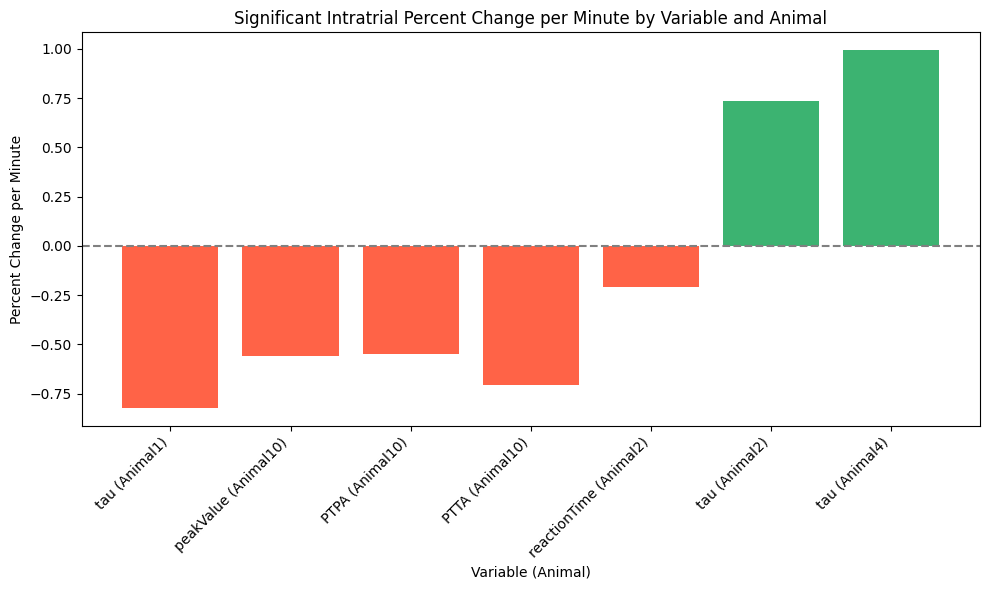

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Load significant intratrial trends (trend_df)
trend_df = pd.read_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT.xlsx"))

# Plot percent_change_per_minute by variable and animal, colored by direction
plt.figure(figsize=(10, 6))
colors = trend_df['direction'].map({'increase': 'mediumseagreen', 'decrease': 'tomato', 'none': 'gray'})
labels = trend_df['variable'] + " (" + trend_df['animal'] + ")"
plt.bar(labels, trend_df['percent_change_per_minute'], color=colors)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('Percent Change per Minute')
plt.xlabel('Variable (Animal)')
plt.title('Significant Intratrial Percent Change per Minute by Variable and Animal')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [85]:
import pandas as pd

# Load significant intratrial trends
trend_df = pd.read_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT.xlsx"))

# Define metrics
strength_metrics = ['AUC', 'PTPA', 'PTTA', 'RMS', 'peakValue']
reaction_metrics = ['reactionTime', 'peakTime']

# Only keep strength metrics
trend_strength = trend_df[trend_df['variable'].isin(strength_metrics)]
avg_strength_percent_change_per_minute = trend_strength['percent_change_per_minute'].mean()
print(f"Average percent change per minute (strength metrics, significant results): {avg_strength_percent_change_per_minute:.3f}")

# Only keep reaction metrics
trend_reaction = trend_df[trend_df['variable'].isin(reaction_metrics)]
avg_reaction_percent_change_per_minute = trend_reaction['percent_change_per_minute'].mean()
print(f"Average percent change per minute (reaction metrics, significant results): {avg_reaction_percent_change_per_minute:.3f}")

Average percent change per minute (strength metrics, significant results): -0.604
Average percent change per minute (reaction metrics, significant results): -0.208


| Animal    | Date     | Variable      | Slope/Trial   | r         | p-value   | Direction | % Change    | % Change/Min |
|-----------|----------|---------------|---------------|-----------|-----------|-----------|-------------|--------------|
| Animal1   | April16  | tau           | -0.628523     | -0.469065 | 0.049564  | decrease  | -21.98      | -0.73        |
| Animal6   | April16  | reactionTime  |  0.025215     |  0.562720 | 0.015049  | increase  |  10.48      |  0.35        |
| Animal6   | April16  | RMS           | -0.146092     | -0.495251 | 0.036636  | decrease  |  -5.99      | -0.20        |
| Animal6   | April16  | AUC           | -40.141711    | -0.506415 | 0.031988  | decrease  |  -7.39      | -0.25        |
| Animal2   | May20    | tau           |  0.811059     |  0.543683 | 0.019691  | increase  |  25.10      |  0.84        |
| Animal4   | May20    | peakValue     |  0.684392     |  0.481530 | 0.043039  | increase  |   6.13      |  0.20        |
| Animal4   | May20    | PTPA          |  0.690802     |  0.482848 | 0.042389  | increase  |   6.11      |  0.20        |
| Animal4   | May20    | PTTA          |  0.636672     |  0.490890 | 0.038586  | increase  |   3.75      |  0.12        |
| Animal4   | May20    | RMS           |  0.196448     |  0.487877 | 0.039979  | increase  |   6.43      |  0.21        |
| Animal4   | May20    | percentPPI    | -0.335797     | -0.496195 | 0.042781  | decrease  | -44.18      | -1.47        |
| Animal2   | June26   | reactionTime  | -0.010675     | -0.500549 | 0.034370  | decrease  |  -9.09      | -0.30        |
| Animal2   | June26   | percentPPI    | -0.257872     | -0.492331 | 0.044683  | decrease  | -86.65      | -2.89        |
| Animal4   | June26   | tau           |  0.810639     |  0.501556 | 0.033952  | increase  |  41.93      |  1.40        |
| Animal15  | June26   | difference    | -0.150698     | -0.476009 | 0.045843  | decrease  |  -2.00      | -0.07        |


---

## Date Differences

In [86]:
# ...existing code...

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

date_results = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in variables:
        # Non-parametric Kruskal-Wallis for all metrics
        groups = [group[var].dropna().values for _, group in df_sex.groupby('date')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None
            if p < 0.05:
                try:
                    dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='date', p_adjust='bonferroni')
                    min_p = dunn.replace(0, float('nan')).min().min()
                    idx = dunn.stack().idxmin()
                    date1, date2 = idx
                    vals1 = df_sex[df_sex['date'] == date1][var].dropna()
                    vals2 = df_sex[df_sex['date'] == date2][var].dropna()
                    u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                    n1, n2 = len(vals1), len(vals2)
                    eff = 1 - (2 * u) / (n1 * n2)
                    mean_diff = vals1.mean() - vals2.mean()
                    posthoc_p = min_p
                    posthoc_test = "Dunn"
                except Exception:
                    posthoc_p, posthoc_test, mean_diff = None, "Dunn", None
        else:
            stat, p, posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None, None, None
        date_results.append({
            'sex': sex,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p is not None and p < 0.05,
            'posthoc_p': posthoc_p,
            'posthoc_test': posthoc_test,
            'date1': date1,
            'date2': date2,
            'effect_strength': eff,
            'mean_diff': mean_diff
        })

test_date = pd.DataFrame(date_results)
print(test_date)

test_date.to_excel(os.path.join(output_dir, "TEST_DATE.xlsx"), index=False)
# ...existing code...

       sex      variable       stat             p  significant     posthoc_p  \
0   female  reactionTime  43.929063  2.890182e-10         True  3.050390e-10   
1   female      peakTime   2.059444  3.571063e-01        False           NaN   
2   female    difference  39.399543  2.782902e-09         True  3.186709e-08   
3   female     peakValue  69.247566  9.185060e-16         True  2.715202e-15   
4   female          PTPA  69.316402  8.874308e-16         True  2.694192e-15   
5   female          PTTA  65.644138  5.566171e-15         True  2.274251e-14   
6   female           RMS  72.741868  1.600678e-16         True  2.419218e-16   
7   female           tau   3.519469  1.720905e-01        False           NaN   
8   female           AUC  90.914102  1.812398e-20         True  1.281914e-20   
9     male  reactionTime   5.037403  8.056417e-02        False           NaN   
10    male      peakTime   7.910185  1.915689e-02         True  3.552861e-02   
11    male    difference   1.896364  3.8

In [87]:
# ...existing code...

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

date_results_merged_sex = []

for var in variables:
    # Non-parametric Kruskal-Wallis for all metrics, merged by sex
    groups = [group[var].dropna().values for _, group in df.groupby('date')]
    groups = [g for g in groups if len(g) > 1]
    stat, p, posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None, None, None
    if len(groups) > 1:
        stat, p = kruskal(*groups)
        if p < 0.05:
            try:
                dunn = sp.posthoc_dunn(df, val_col=var, group_col='date', p_adjust='bonferroni')
                min_p = dunn.replace(0, float('nan')).min().min()
                idx = dunn.stack().idxmin()
                date1, date2 = idx
                vals1 = df[df['date'] == date1][var].dropna()
                vals2 = df[df['date'] == date2][var].dropna()
                u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                n1, n2 = len(vals1), len(vals2)
                eff = 1 - (2 * u) / (n1 * n2)
                mean_diff = vals1.mean() - vals2.mean()
                posthoc_p = min_p
                posthoc_test = "Dunn"
            except Exception:
                posthoc_p, posthoc_test, mean_diff = None, "Dunn", None
    date_results_merged_sex.append({
        'variable': var,
        'stat': stat,
        'p': p,
        'significant': p is not None and p < 0.05,
        'posthoc_p': posthoc_p,
        'posthoc_test': posthoc_test,
        'date1': date1,
        'date2': date2,
        'effect_strength': eff,
        'mean_diff': mean_diff
    })

test_date_merged_sex = pd.DataFrame(date_results_merged_sex)
print(test_date_merged_sex)

test_date_merged_sex.to_excel(os.path.join(output_dir, "TEST_DATE_MERGED_SEX.xlsx"), index=False)
# ...existing code...

       variable       stat             p  significant     posthoc_p  \
0  reactionTime  37.597457  6.851979e-09         True  1.784506e-08   
1      peakTime   4.206166  1.220795e-01        False           NaN   
2    difference  11.037369  4.011120e-03         True  3.288142e-03   
3     peakValue  46.201293  9.279329e-11         True  5.263573e-10   
4          PTPA  46.275476  8.941451e-11         True  5.326969e-10   
5          PTTA  45.794254  1.137376e-10         True  8.905545e-10   
6           RMS  43.918914  2.904885e-10         True  2.430369e-10   
7           tau   7.413196  2.456094e-02         True  2.314641e-02   
8           AUC  56.121387  6.507224e-13         True  2.109496e-13   

  posthoc_test    date1   date2  effect_strength    mean_diff  
0         Dunn  April16  June26        -0.455847     0.779012  
1         None     None    None              NaN          NaN  
2         Dunn  April16  June26         0.234654    -0.699074  
3         Dunn  April16  June26  

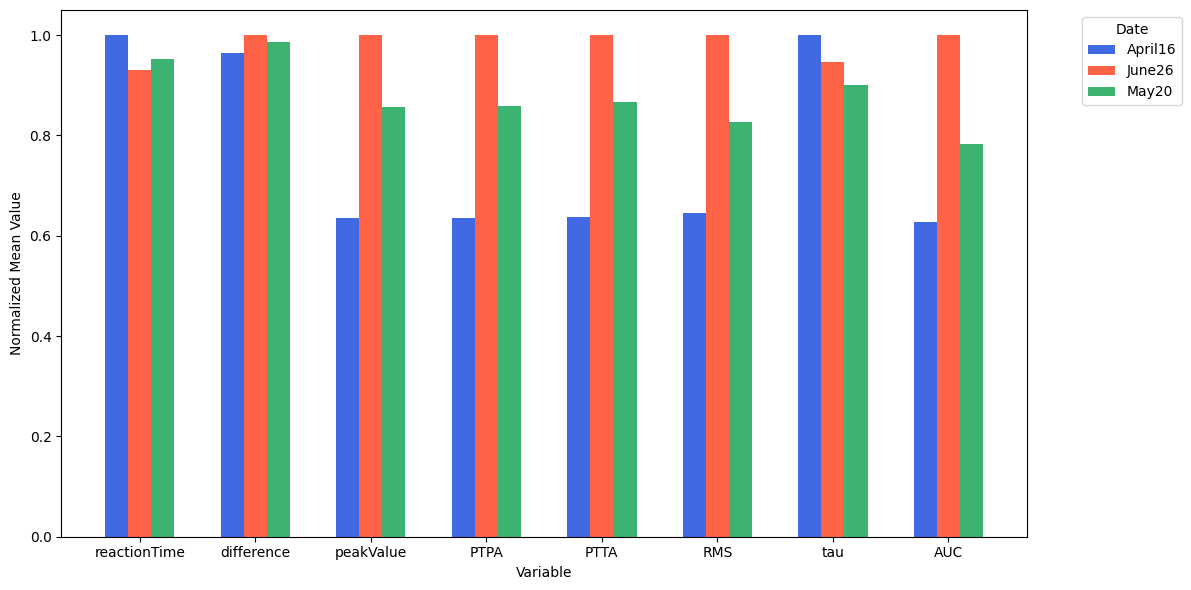

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your results and raw data
test_date_merged_sex = pd.read_excel(os.path.join(output_dir, "TEST_DATE_MERGED_SEX.xlsx"))
df = dfs['RESULTS_MTT_MERGED']

# Only keep significant results
sig = test_date_merged_sex[test_date_merged_sex['significant'] == True]

# Get all unique dates and variables
dates = df['date'].unique()
variables = sig['variable'].unique()

# Prepare data: mean raw value for each variable/date
bar_data = []
for var in variables:
    means = []
    for date in dates:
        vals = df[df['date'] == date][var].dropna()
        means.append(vals.mean())
    # Normalize to [-1, 1] for each variable
    max_abs = np.max(np.abs(means))
    means_norm = [m / max_abs if max_abs != 0 else 0 for m in means]
    bar_data.append(means_norm)
bar_data = np.array(bar_data)  # shape: (variables, dates)



# Plot layered/grouped bar plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(variables))
colors = ['royalblue', 'tomato', 'mediumseagreen'][:len(dates)]

for i, date in enumerate(dates):
    ax.bar(x + i*bar_width, bar_data[:, i], width=bar_width, label=date, color=colors[i])

ax.set_xticks(x + bar_width)
ax.set_xticklabels(variables)
ax.set_ylabel('Normalized Mean Value')
ax.set_xlabel('Variable')
ax.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

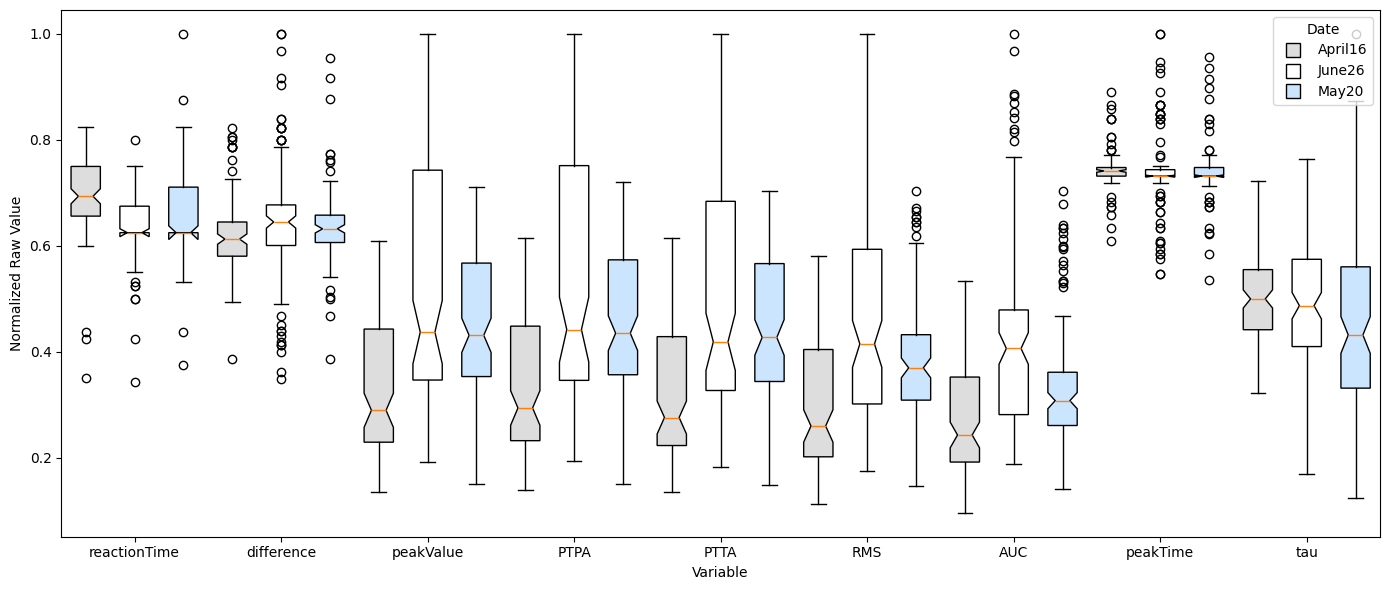

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your results and raw data
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE.xlsx"))
df = dfs['RESULTS_MTT_MERGED']

# Only keep significant results
sig = test_date[test_date['significant'] == True]

# Get all unique dates and variables
dates = df['date'].unique()
variables = sig['variable'].unique()

# Prepare data for boxplot: raw values for each variable/date
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, date in enumerate(dates):
        vals = df[df['date'] == date][var].dropna()
        # Normalize to [-1, 1] for each variable
        max_abs = np.max(np.abs(df[var].dropna()))
        vals_norm = vals / max_abs if max_abs != 0 else vals
        data.append(vals_norm)
        positions.append(i*len(dates) + j)
        labels.append(f"{var}" if j == 0 else "")  # Only label once per variable
        box_colors.append(['#DDDDDD', '#FFFFFF', '#CCE5FF', '#FFCCCC', '#CCFFCC'][j % 5])  # Color by date

plt.figure(figsize=(14, 6))
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

plt.xticks([i*len(dates)+(len(dates)-1)/2 for i in range(len(variables))], variables)
plt.ylabel('Normalized Raw Value')
plt.xlabel('Variable')
plt.legend(handles=[
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#DDDDDD', label=dates[0], linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#FFFFFF', label=dates[1], linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#CCE5FF', label=dates[2], linestyle='None')
], title='Date', loc='upper right')
plt.tight_layout()
plt.show()

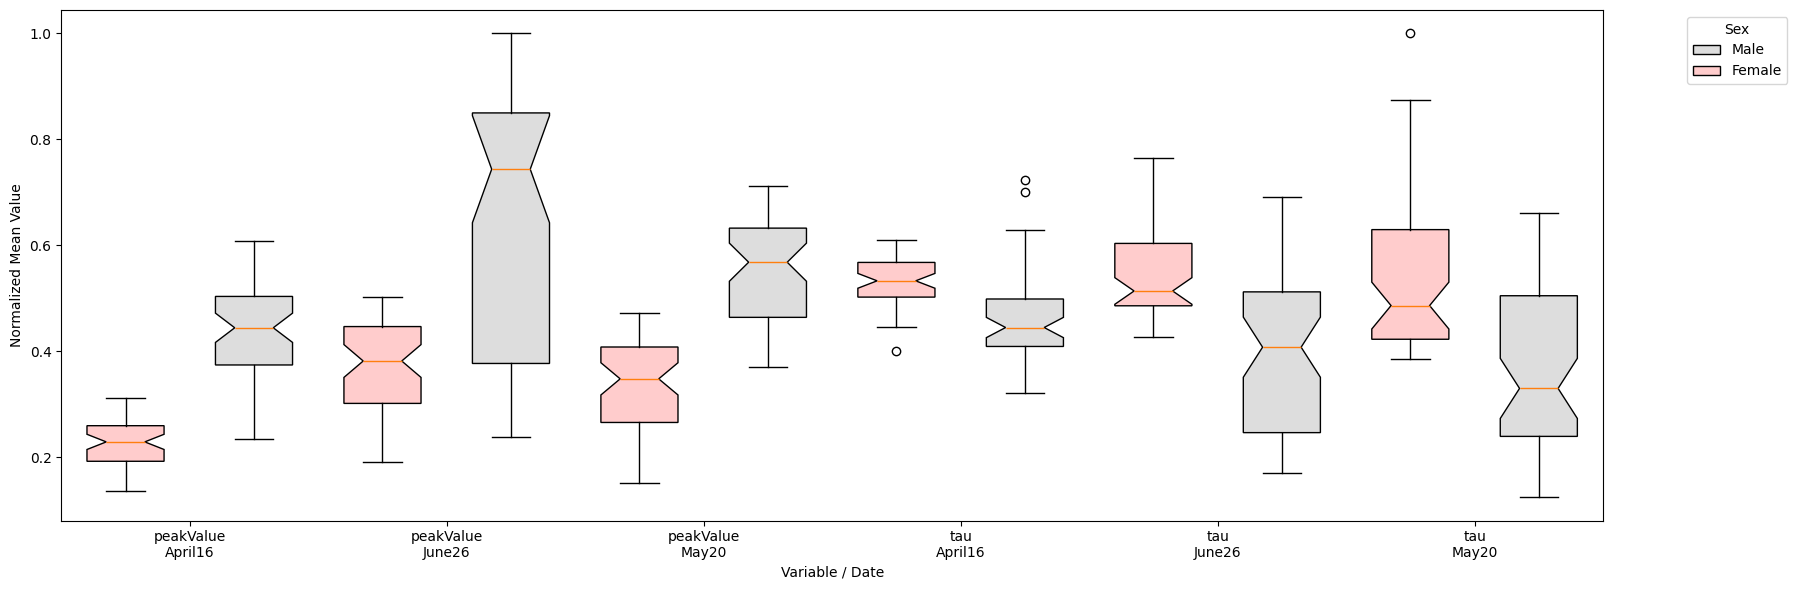

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your results and raw data
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE.xlsx"))
df = dfs['RESULTS_MTT_MERGED']

# Only keep significant results for strength metrics
strength_metrics = ['peakValue', 'tau']
sig = test_date[(test_date['significant'] == True) & (test_date['variable'].isin(strength_metrics))]

dates = df['date'].unique()
sexes = df['sex'].unique()
variables = sig['variable'].unique()

# Prepare data for boxplot: raw values for each variable/date/sex
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, date in enumerate(dates):
        for k, sex in enumerate(sexes):
            vals = df[(df['date'] == date) & (df['sex'] == sex)][var].dropna()
            # Normalize to [-1, 1] for each variable
            max_abs = np.max(np.abs(df[var].dropna()))
            vals_norm = vals / max_abs if max_abs != 0 else vals
            data.append(vals_norm)
            # Position: variable * (dates*sexes) + date * sexes + sex
            positions.append(i*len(dates)*len(sexes) + j*len(sexes) + k)
            # X tick label for each date
            labels.append(f"{date}" if k == 0 else "")
            # Color by sex
            box_colors.append('#DDDDDD' if sex == 'male' else '#FFCCCC')

plt.figure(figsize=(18, 6))
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

# X ticks: one per date per variable
xticks = []
xticklabels = []
for i in range(len(variables)):
    for j in range(len(dates)):
        pos = i*len(dates)*len(sexes) + j*len(sexes) + 0.5
        xticks.append(pos)
        xticklabels.append(f"{variables[i]}\n{dates[j]}")
plt.xticks(xticks, xticklabels)
plt.ylabel('Normalized Mean Value')
plt.xlabel('Variable / Date')

# Legend for sex
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(facecolor='#DDDDDD', edgecolor='black', label='Male'),
    mpatches.Patch(facecolor='#FFCCCC', edgecolor='black', label='Female'),
]
plt.legend(handles=legend_handles, title='Sex', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

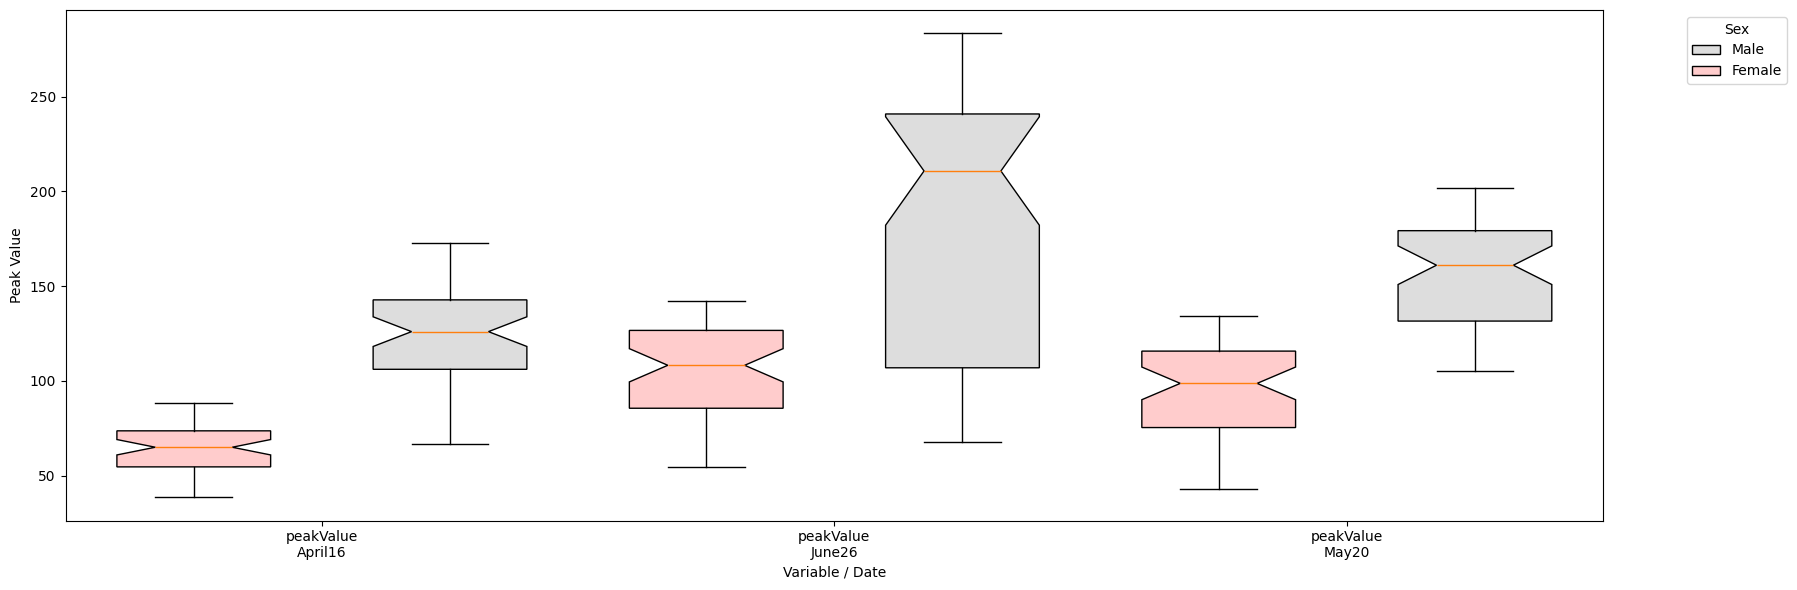

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load your results and raw data
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE.xlsx"))
df = dfs['RESULTS_MTT_MERGED']

# Only keep significant results for strength metrics
strength_metrics = ['peakValue']
sig = test_date[(test_date['significant'] == True) & (test_date['variable'].isin(strength_metrics))]

dates = df['date'].unique()
sexes = df['sex'].unique()
variables = sig['variable'].unique()

# Prepare data for boxplot: raw values for each variable/date/sex (NO normalization)
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, date in enumerate(dates):
        for k, sex in enumerate(sexes):
            vals = df[(df['date'] == date) & (df['sex'] == sex)][var].dropna()
            data.append(vals)
            # Position: variable * (dates*sexes) + date * sexes + sex
            positions.append(i*len(dates)*len(sexes) + j*len(sexes) + k)
            # X tick label for each date
            labels.append(f"{date}" if k == 0 else "")
            # Color by sex
            box_colors.append('#DDDDDD' if sex == 'male' else '#FFCCCC')

plt.figure(figsize=(18, 6))
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

# X ticks: one per date per variable
xticks = []
xticklabels = []
for i in range(len(variables)):
    for j in range(len(dates)):
        pos = i*len(dates)*len(sexes) + j*len(sexes) + 0.5
        xticks.append(pos)
        xticklabels.append(f"{variables[i]}\n{dates[j]}")
plt.xticks(xticks, xticklabels)
plt.ylabel('Peak Value')
plt.xlabel('Variable / Date')

# Legend for sex
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(facecolor='#DDDDDD', edgecolor='black', label='Male'),
    mpatches.Patch(facecolor='#FFCCCC', edgecolor='black', label='Female'),
]
plt.legend(handles=legend_handles, title='Sex', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [92]:
# Count how many sex/variable groups show significant date deviations

import pandas as pd
from scipy.stats import kruskal

df = dfs['RESULTS_MTT_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

significant_count = 0
results = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in variables:
        groups = [group[var].dropna().values for _, group in df_sex.groupby('date')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            if p < 0.05:
                significant_count += 1
                results.append({'sex': sex, 'variable': var, 'stat': stat, 'p': p})

print(f"Number of sex/variable groups with significant date deviations: {significant_count}")
pd.DataFrame(results).to_excel(os.path.join(output_dir, "SIGNIFICANT_DATE_SPLIT.xlsx"), index=False)

Number of sex/variable groups with significant date deviations: 14


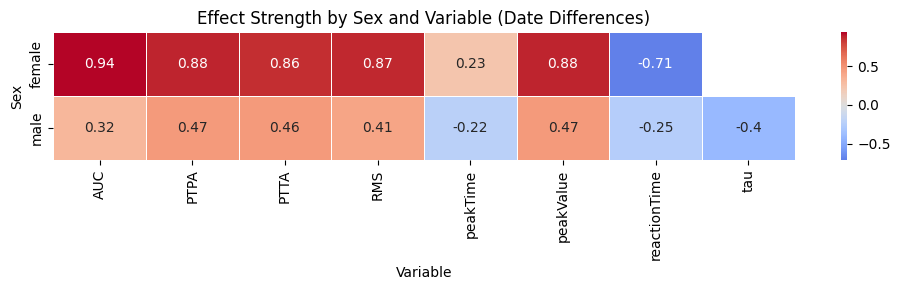

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Paste your results as a DataFrame
data = {
    "sex": ["female"]*8 + ["male"]*8,
    "variable": ["AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau",
                 "AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau"],
    "effect_strength": [0.940329, 0.877915, 0.859396, 0.871742, 0.229424, 0.878944, -0.711248, np.nan,
                       0.316187, 0.466392, 0.463649, 0.414952, -0.223594, 0.467078, -0.247942, -0.403978]
}
df = pd.DataFrame(data)

# Pivot for heatmap (sex x variable)
heatmap_data = df.pivot(index="sex", columns="variable", values="effect_strength")

plt.figure(figsize=(10, 3))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Sex and Variable (Date Differences)")
plt.ylabel("Sex")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()

## Summary of Date Differences (Non-parametric Tests)

All results use the **Kruskal-Wallis test** for date effects, with **Dunn's post hoc** for pairwise comparison.  
Effect strength is rank-biserial correlation.  
Mean difference is (date1 mean - date2 mean) for the most significant pair.

| Sex    | Variable      | Stat     | p-value    | Significant | Posthoc p   | Posthoc Test | Date1    | Date2    | Effect Strength | Mean Diff    |
|--------|--------------|----------|------------|-------------|-------------|--------------|----------|----------|-----------------|-------------|
| female | reactionTime | 43.71    | 3.23e-10   | True        | 3.22e-10    | Dunn         | April16  | June26   | -0.71           | 1.43        |
| female | peakTime     | 6.58     | 3.72e-02   | True        | 5.04e-02    | Dunn         | June26   | May20    | 0.23            | -0.30       |
| female | difference   | 41.65    | 9.05e-10   | True        | 4.86e-08    | Dunn         | April16  | June26   | 0.59            | -2.02       |
| female | peakValue    | 69.98    | 6.37e-16   | True        | 2.54e-15    | Dunn         | April16  | June26   | 0.88            | -43.05      |
| female | PTPA         | 69.82    | 6.90e-16   | True        | 2.88e-15    | Dunn         | April16  | June26   | 0.88            | -42.54      |
| female | PTTA         | 66.35    | 3.90e-15   | True        | 2.26e-14    | Dunn         | April16  | June26   | 0.86            | -38.19      |
| female | RMS          | 73.48    | 1.11e-16   | True        | 2.55e-16    | Dunn         | April16  | June26   | 0.87            | -19.48      |
| female | tau          | 3.37     | 0.185      | False       | NaN         | None         | None     | None     | NaN             | NaN         |
| female | AUC          | 92.46    | 8.38e-21   | True        | 8.01e-21    | Dunn         | April16  | June26   | 0.94            | -6202.25    |
| female | percentPPI   | 0.000045 | 1.00       | False       | NaN         | None         | None     | None     | NaN             | NaN         |
| male   | reactionTime | 6.05     | 4.86e-02   | True        | 4.53e-02    | Dunn         | April16  | May20    | -0.25           | 0.22        |
| male   | peakTime     | 7.31     | 2.59e-02   | True        | 5.62e-02    | Dunn         | April16  | June26   | -0.22           | 0.98        |
| male   | difference   | 1.65     | 0.438      | False       | NaN         | None         | None     | None     | NaN             | NaN         |
| male   | peakValue    | 34.53    | 3.18e-08   | True        | 4.55e-08    | Dunn         | April16  | June26   | 0.47            | -64.83      |
| male   | PTPA         | 35.12    | 2.36e-08   | True        | 3.71e-08    | Dunn         | April16  | June26   | 0.47            | -64.85      |
| male   | PTTA         | 35.43    | 2.02e-08   | True        | 3.87e-08    | Dunn         | April16  | June26   | 0.46            | -58.11      |
| male   | RMS          | 16.25    | 2.96e-04   | True        | 1.71e-04    | Dunn         | April16  | June26   | 0.41            | -21.74      |
| male   | tau          | 13.65    | 1.09e-03   | True        | 8.54e-04    | Dunn         | April16  | May20    | -0.40           | 28.50       |
| male   | AUC          | 8.07     | 1.77e-02   | True        | 1.69e-02    | Dunn         | April16  | June26   | 0.32            | -5053.16    |
| male   | percentPPI   | 0.000060 | 1.00       | False       | NaN         | None         | None     | None     | NaN             | NaN         |

**Interpretation:**
- **Females:** Significant date effects for all metrics except tau and percentPPI. Largest differences are between April16 and June26, with very large effect strengths for strength metrics (peakValue, PTPA, PTTA, RMS, AUC).
- **Males:** Significant date effects for all metrics except difference and percentPPI. Most pronounced for peakValue, PTPA, PTTA, RMS, tau, and AUC (April16 vs June26 or May20), with moderate to large effect strengths.
- **Conclusion:** Date (batch/day) strongly impacts most metrics for both sexes, especially strength metrics. Always control for date in analysis.

In [94]:
# Calculate average effect strength for date differences, split by sex

import pandas as pd

# Load your results (replace with actual path if needed)
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE.xlsx"))

# Only keep significant results
sig = test_date[test_date['significant'] == True]

# Calculate average effect strength for each sex
avg_female = sig[sig['sex'] == 'female']['effect_strength'].mean()
avg_male = sig[sig['sex'] == 'male']['effect_strength'].mean()

# Calculate how much stronger the effect is for females
strength_ratio = avg_female / avg_male if avg_male != 0 else None
strength_diff = avg_female - avg_male

print(f"Average effect strength (female): {avg_female:.3f}")
print(f"Average effect strength (male): {avg_male:.3f}")
print(f"Females have {strength_ratio:.2f}x stronger effect on average (ratio), or {strength_diff:.3f} higher (difference).")

Average effect strength (female): 0.621
Average effect strength (male): 0.213
Females have 2.92x stronger effect on average (ratio), or 0.409 higher (difference).


# ---> split by date, especially for females (may be estrous cycle?)

---

In [131]:
# ...existing code...

import pandas as pd
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

sex_diff_results = []

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    for var in variables:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        mean_diff = vals_male.mean() - vals_female.mean() if len(vals_male) > 0 and len(vals_female) > 0 else None
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
            n1, n2 = len(vals_male), len(vals_female)
            u, _ = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
            eff = 1 - (2 * u) / (n1 * n2)
            # Dunn's posthoc
            try:
                data = pd.DataFrame({var: pd.concat([vals_male, vals_female]),
                                    'group': ['male'] * len(vals_male) + ['female'] * len(vals_female)})
                dunn = sp.posthoc_dunn(data, val_col=var, group_col='group', p_adjust='bonferroni')
                posthoc_p = dunn.loc['male', 'female']
                posthoc_test = "Dunn"
            except Exception:
                posthoc_p = None
                posthoc_test = "Dunn"
        else:
            stat, p, eff, posthoc_p, posthoc_test = None, None, None, None, None
        sex_diff_results.append({
            'date': date,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p is not None and p < 0.05,
            'effect_strength': eff,
            'posthoc_p': posthoc_p,
            'posthoc_test': posthoc_test,
            'mean_diff': mean_diff,
            'test': 'mannwhitneyu'
        })

test_sex = pd.DataFrame(sex_diff_results)
print(test_sex)

test_sex.to_excel(os.path.join(output_dir, "TEST_SEX.xlsx"), index=False)
# ...existing code...

       date      variable    stat             p  significant  effect_strength  \
0   April16  reactionTime   576.5  5.150354e-08         True         0.604595   
1   April16      peakTime  1682.0  1.542212e-01        False        -0.153635   
2   April16    difference  2136.0  2.880648e-05         True        -0.465021   
3   April16     peakValue  2854.5  9.678487e-18         True        -0.957819   
4   April16          PTPA  2853.0  1.048896e-17         True        -0.956790   
5   April16          PTTA  2866.0  5.226067e-18         True        -0.965706   
6   April16           RMS  2845.0  1.605321e-17         True        -0.951303   
7   April16           tau   589.0  9.477762e-08         True         0.596022   
8   April16           AUC  2769.0  8.124392e-16         True        -0.899177   
9    June26  reactionTime  1585.5  4.104878e-01        False        -0.087449   
10   June26      peakTime  1147.5  4.662744e-02         True         0.212963   
11   June26    difference  1

In [133]:
import pandas as pd

# Replace with your actual DataFrame if needed
df = pd.read_excel(os.path.join(output_dir, "TEST_SEX.xlsx"))
# For your pasted data, assume it's in a DataFrame called df

# Only keep numeric columns for averaging
cols_to_avg = ['stat', 'p', 'effect_strength', 'mean_diff']
avg_df = df.groupby('variable')[cols_to_avg].mean().reset_index()

# Optionally, keep the first posthoc_test and test type for each variable
for col in ['posthoc_test', 'test']:
    avg_df[col] = df.groupby('variable')[col].first().values

print(avg_df)
avg_df.to_excel(os.path.join(output_dir, "TEST_SEX_AVG_ACROSS_DATES.xlsx"), index=False)

       variable         stat             p  effect_strength    mean_diff  \
0           AUC  2204.000000  5.177619e-03        -0.511660  4717.336435   
1          PTPA  2636.500000  9.470276e-08        -0.808299    67.600286   
2          PTTA  2647.500000  3.323546e-08        -0.815844    61.581297   
3           RMS  2505.833333  2.322687e-06        -0.718679    23.865355   
4    difference  1531.333333  1.085323e-01        -0.050297    -0.237243   
5      peakTime  1283.166667  6.852527e-02         0.119913    -0.627366   
6     peakValue  2637.166667  1.027223e-07        -0.808756    68.009774   
7  reactionTime  1104.500000  1.549259e-01         0.242455    -0.390123   
8           tau   636.000000  6.814325e-07         0.563786   -36.666815   

  posthoc_test          test  
0         Dunn  mannwhitneyu  
1         Dunn  mannwhitneyu  
2         Dunn  mannwhitneyu  
3         Dunn  mannwhitneyu  
4         Dunn  mannwhitneyu  
5         Dunn  mannwhitneyu  
6         Dunn  mannwh

In [134]:
import pandas as pd

# Load the results
df = pd.read_excel(os.path.join(output_dir, "TEST_SEX.xlsx"))

# Columns to summarize
cols_to_range = ['stat', 'p', 'effect_strength', 'mean_diff']

# Group by variable and get mean for stat/p, min/max for effect_strength/mean_diff
summary = df.groupby('variable').agg(
    stat_mean=('stat', 'mean'),
    p_mean=('p', 'mean'),
    effect_strength_min=('effect_strength', 'min'),
    effect_strength_max=('effect_strength', 'max'),
    mean_diff_min=('mean_diff', 'min'),
    mean_diff_max=('mean_diff', 'max'),
    posthoc_test=('posthoc_test', 'first'),
    test=('test', 'first')
).reset_index()

print(summary)
summary.to_excel(os.path.join(output_dir, "TEST_SEX_RANGE_ACROSS_DATES.xlsx"), index=False)

       variable    stat_mean        p_mean  effect_strength_min  \
0           AUC  2204.000000  5.177619e-03            -0.899177   
1          PTPA  2636.500000  9.470276e-08            -0.956790   
2          PTTA  2647.500000  3.323546e-08            -0.965706   
3           RMS  2505.833333  2.322687e-06            -0.951303   
4    difference  1531.333333  1.085323e-01            -0.465021   
5      peakTime  1283.166667  6.852527e-02            -0.153635   
6     peakValue  2637.166667  1.027223e-07            -0.957819   
7  reactionTime  1104.500000  1.549259e-01            -0.087449   
8           tau   636.000000  6.814325e-07             0.541838   

   effect_strength_max  mean_diff_min  mean_diff_max posthoc_test  \
0            -0.273663    3763.752460    5741.291824         Dunn   
1            -0.573388      59.125719      81.008065         Dunn   
2            -0.594993      53.918571      73.334941         Dunn   
3            -0.502058      19.974796      26.923994 

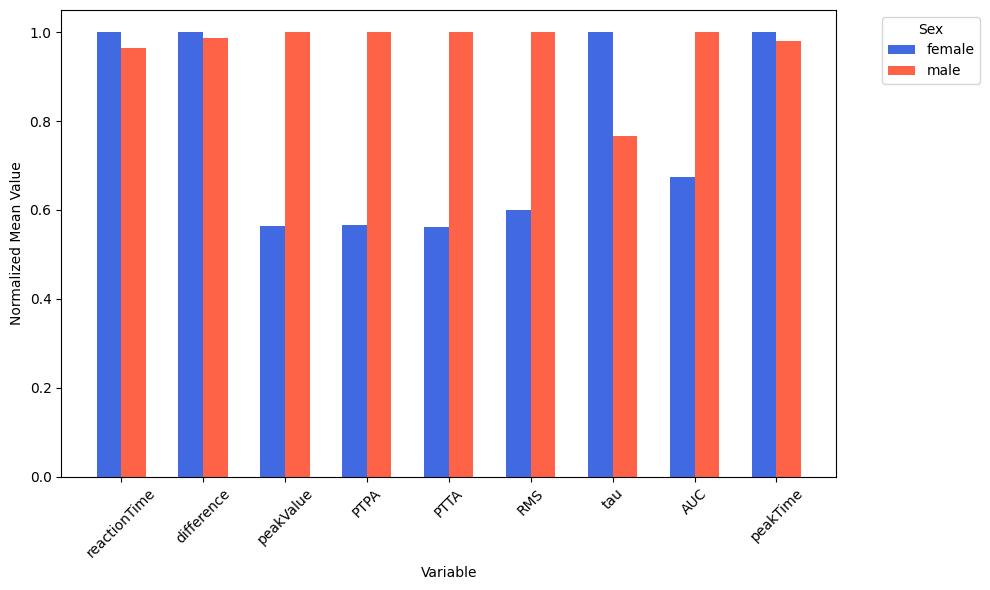

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your results and raw data
test_sex = pd.read_excel(os.path.join(output_dir, "TEST_SEX.xlsx"))
df = dfs['RESULTS_MTT_MERGED']

# Only keep significant results
sig = test_sex[test_sex['significant'] == True]

# Get all unique sexes and variables
sexes = df['sex'].unique()
variables = sig['variable'].unique()

# Prepare data: mean raw value for each variable/sex
bar_data = []
for var in variables:
    means = []
    for sex in sexes:
        vals = df[df['sex'] == sex][var].dropna()
        means.append(vals.mean())
    # Normalize to [-1, 1] for each variable
    max_abs = np.max(np.abs(means))
    means_norm = [m / max_abs if max_abs != 0 else 0 for m in means]
    bar_data.append(means_norm)
bar_data = np.array(bar_data)  # shape: (variables, sexes)

# Plot layered/grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3
x = np.arange(len(variables))
colors = ['royalblue', 'tomato'][:len(sexes)]

for i, sex in enumerate(sexes):
    ax.bar(x + i*bar_width, bar_data[:, i], width=bar_width, label=sex, color=colors[i])

ax.set_xticks(x + bar_width/2)
ax.set_xticklabels(variables)
ax.set_ylabel('Normalized Mean Value')
ax.set_xlabel('Variable')
ax.legend(title='Sex', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

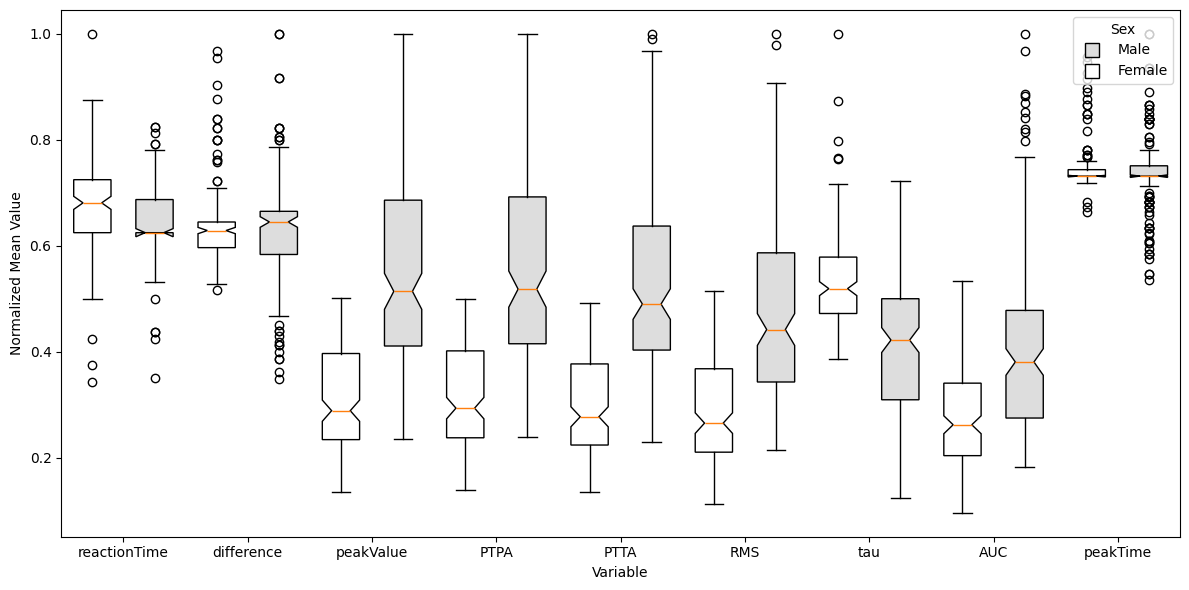

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load your results and raw data
test_sex = pd.read_excel(os.path.join(output_dir, "TEST_SEX.xlsx"))
df = dfs['RESULTS_MTT_MERGED']

# Only keep significant results
sig = test_sex[test_sex['significant'] == True]

# Get all unique sexes and variables
sexes = df['sex'].unique()
variables = sig['variable'].unique()

# Prepare data for boxplot: raw values for each variable/sex
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, sex in enumerate(sexes):
        vals = df[df['sex'] == sex][var].dropna()
        # Normalize to [-1, 1] for each variable
        max_abs = np.max(np.abs(df[var].dropna()))
        vals_norm = vals / max_abs if max_abs != 0 else vals
        data.append(vals_norm)
        positions.append(i*2 + j)
        labels.append(f"{var}" if j == 0 else "")  # Only label once per variable
        box_colors.append('#DDDDDD' if sex == 'male' else '#FFFFFF')  # Gray for male, white for female

plt.figure(figsize=(12, 6))
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

plt.xticks([i*2+0.5 for i in range(len(variables))], variables)#, rotation=45)
plt.ylabel('Normalized Mean Value')
plt.xlabel('Variable')
#plt.title('Normalized Boxplot of Raw Values by Variable and Sex (Significant Results Only)')
plt.legend(handles=[
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#DDDDDD', label='Male', linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#FFFFFF', label='Female', linestyle='None')
], title='Sex', loc='upper right')
plt.tight_layout()
plt.show()

In [98]:
# Count how many date/variable groups show significant sex deviations, split by strength and reaction metrics

import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']

# Define strength and reaction metrics
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = [v for v in df.columns if v not in strength_metrics + ['animal', 'experiment', 'sex', 'date', 'IPI']]

results_strength = []
results_reaction = []
count_strength = 0
count_reaction = 0

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    # Strength metrics
    for var in strength_metrics:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
            if p < 0.05:
                count_strength += 1
                results_strength.append({'date': date, 'variable': var, 'stat': stat, 'p': p})
    # Reaction metrics
    for var in reaction_metrics:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = mannwhitneyu(vals_male, vals_female, alternative='two-sided')
            if p < 0.05:
                count_reaction += 1
                results_reaction.append({'date': date, 'variable': var, 'stat': stat, 'p': p})

print(f"Significant sex deviations (strength metrics): {count_strength}")
print(f"Significant sex deviations (reaction metrics): {count_reaction}")

pd.DataFrame(results_strength).to_excel(os.path.join(output_dir, "SIGNIFICANT_SEX_SPLIT_STRENGTH.xlsx"), index=False)
pd.DataFrame(results_reaction).to_excel(os.path.join(output_dir, "SIGNIFICANT_SEX_SPLIT_REACTION.xlsx"), index=False)

Significant sex deviations (strength metrics): 18
Significant sex deviations (reaction metrics): 4


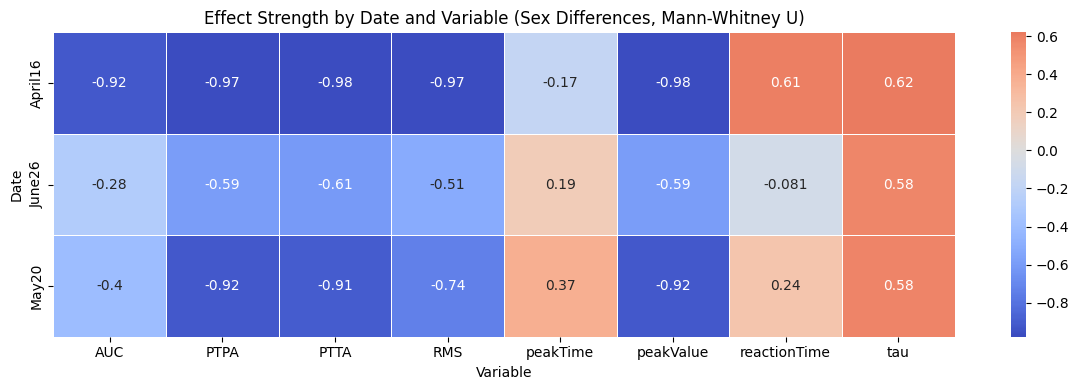

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paste your results as a DataFrame
data = {
    "date": ["April16"]*8 + ["June26"]*8 + ["May20"]*8,
    "variable": ["AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau"]*3,
    "effect_strength": [
        -0.921811, -0.973251, -0.978738, -0.969822, -0.167353, -0.975995, 0.605967, 0.620027,
        -0.281893, -0.590535, -0.607339, -0.512346, 0.188272, -0.589163, -0.080590, 0.575446,
        -0.399177, -0.918038, -0.908779, -0.736283, 0.370713, -0.916667, 0.236626, 0.582990
    ]
}
df = pd.DataFrame(data)

# Pivot for heatmap (date x variable)
heatmap_data = df.pivot(index="date", columns="variable", values="effect_strength")

plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Date and Variable (Sex Differences, Mann-Whitney U)")
plt.ylabel("Date")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()

## Summary of Sex Differences by Date (Significant Results Only, Non-parametric Tests)

All results use the **Mann-Whitney U test** for sex differences and **Dunn's post hoc** for pairwise comparison.  
Effect strength is rank-biserial correlation (positive = higher in males, negative = higher in females).  
Mean difference is (male mean - female mean).

| Date     | Variable      | Stat    | p-value    | Effect Strength | Dunn p      | Mean Diff   |
|----------|--------------|---------|------------|-----------------|-------------|-------------|
| April16  | reactionTime | 574.5   | 4.73e-08   | 0.61            | 4.65e-08    | -1.05       |
| April16  | difference   | 2104.0  | 6.94e-05   | -0.44           | 6.86e-05    | 1.78        |
| April16  | peakValue    | 2881.0  | 2.32e-18   | -0.98           | 2.26e-18    | 61.08       |
| April16  | PTPA         | 2877.0  | 2.88e-18   | -0.97           | 2.81e-18    | 60.20       |
| April16  | PTTA         | 2885.0  | 1.87e-18   | -0.98           | 1.82e-18    | 55.28       |
| April16  | RMS          | 2872.0  | 3.78e-18   | -0.97           | 3.68e-18    | 25.17       |
| April16  | tau          | 554.0   | 2.83e-08   | 0.62            | 2.78e-08    | -21.62      |
| April16  | AUC          | 2802.0  | 1.52e-16   | -0.92           | 1.48e-16    | 5809.32     |
| June26   | peakValue    | 2317.0  | 1.33e-07   | -0.59           | 1.31e-07    | 82.86       |
| June26   | PTPA         | 2319.0  | 1.24e-07   | -0.59           | 1.22e-07    | 82.51       |
| June26   | PTTA         | 2343.5  | 5.39e-08   | -0.61           | 5.30e-08    | 75.20       |
| June26   | RMS          | 2205.0  | 4.50e-06   | -0.51           | 4.43e-06    | 27.42       |
| June26   | tau          | 619.0   | 2.58e-07   | 0.58            | 2.53e-07    | -42.61      |
| June26   | AUC          | 1869.0  | 1.17e-02   | -0.28           | 1.16e-02    | 4660.23     |
| May20    | reactionTime | 1113.0  | 0.030      | 0.24            | 3.00e-02    | -0.42       |
| May20    | peakTime     | 917.5   | 0.00062    | 0.37            | 6.10e-04    | -1.31       |
| May20    | peakValue    | 2794.5  | 2.23e-16   | -0.92           | 2.17e-16    | 63.35       |
| May20    | PTPA         | 2796.5  | 2.01e-16   | -0.92           | 1.96e-16    | 63.26       |
| May20    | PTTA         | 2783.0  | 4.01e-16   | -0.91           | 3.91e-16    | 57.83       |
| May20    | RMS          | 2531.5  | 4.31e-11   | -0.74           | 4.22e-11    | 20.13       |
| May20    | tau          | 608.0   | 1.79e-07   | 0.58            | 1.76e-07    | -50.30      |
| May20    | AUC          | 2040.0  | 3.53e-04   | -0.40           | 3.49e-04    | 3762.50     |

**Interpretation:**
- **Strength metrics** (peakValue, PTPA, PTTA, RMS, AUC) show large and highly significant sex differences on all dates (higher in males).
- **Females have higher tau**; males have higher peakValue, RMS, and AUC.
- **Reaction metrics** (reactionTime, peakTime, difference) show significant sex differences on April16 and May20.
- All results are robust to non-normality and outliers.

# ---> strong effect of sex on strength
# ---> weak effect of sex on reaction

---

## Recording Order Differences

In [100]:
# ...existing code...

import pandas as pd
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for metric in metrics:
            vals_early = df_sub[df_sub['group'] == 'early'][metric].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][metric].dropna()
            mean_diff = vals_early.mean() - vals_late.mean() if len(vals_early) > 0 and len(vals_late) > 0 else None
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                n1, n2 = len(vals_early), len(vals_late)
                u, _ = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                effect_strength = 1 - (2 * u) / (n1 * n2)
                try:
                    data = pd.DataFrame({metric: pd.concat([vals_early, vals_late]),
                                        'group': ['early'] * len(vals_early) + ['late'] * len(vals_late)})
                    dunn = sp.posthoc_dunn(data, val_col=metric, group_col='group', p_adjust='bonferroni')
                    posthoc_p = dunn.loc['early', 'late']
                except Exception:
                    posthoc_p = None
                results.append({
                    'sex': sex,
                    'date': date,
                    'metric': metric,
                    'test': 'mannwhitneyu',
                    'stat': stat,
                    'p': p,
                    'effect_strength': effect_strength,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': 'Dunn',
                    'significant': p < 0.05,
                    'mean_diff': mean_diff
                })

test_rec_order = pd.DataFrame(results)

# Count significant results per metric
counts = test_rec_order.groupby('metric')['significant'].sum().reset_index()
counts = counts.rename(columns={'significant': 'significant_count'})
#print(counts)

counts.to_excel(os.path.join(output_dir, "SIGNIFICANT_RECORDER_COUNTS.xlsx"), index=False)
print(test_rec_order)
# ...existing code...

       sex     date        metric          test   stat             p  \
0   female  April16  reactionTime  mannwhitneyu  480.0  3.796243e-03   
1   female  April16      peakTime  mannwhitneyu  117.0  5.320819e-05   
2   female  April16    difference  mannwhitneyu   96.5  2.422120e-05   
3   female  April16     peakValue  mannwhitneyu  250.0  1.774313e-01   
4   female  April16          PTPA  mannwhitneyu  249.0  1.716159e-01   
5   female  April16          PTTA  mannwhitneyu  288.0  5.147860e-01   
6   female  April16           RMS  mannwhitneyu  198.0  2.128733e-02   
7   female  April16           tau  mannwhitneyu  167.0  4.082956e-03   
8   female  April16           AUC  mannwhitneyu  145.0  1.055247e-03   
9   female   June26  reactionTime  mannwhitneyu  502.5  7.912346e-04   
10  female   June26      peakTime  mannwhitneyu  370.0  3.583960e-01   
11  female   June26    difference  mannwhitneyu  222.0  6.060663e-02   
12  female   June26     peakValue  mannwhitneyu  232.5  9.494732

In [101]:
# ...existing code...
import pandas as pd
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
metrics = ['reactionTime', 'peakValue', 'peakTime', 'AUC']  # <-- Added peakTime and AUC
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for metric in metrics:
            vals_early = df_sub[df_sub['group'] == 'early'][metric].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][metric].dropna()
            mean_diff = vals_early.mean() - vals_late.mean() if len(vals_early) > 0 and len(vals_late) > 0 else None
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                n1, n2 = len(vals_early), len(vals_late)
                u, _ = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                effect_strength = 1 - (2 * u) / (n1 * n2)
                try:
                    data = pd.DataFrame({metric: pd.concat([vals_early, vals_late]),
                                        'group': ['early'] * len(vals_early) + ['late'] * len(vals_late)})
                    dunn = sp.posthoc_dunn(data, val_col=metric, group_col='group', p_adjust='bonferroni')
                    posthoc_p = dunn.loc['early', 'late']
                except Exception:
                    posthoc_p = None
                if p < 0.05:
                    results.append({
                        'sex': sex,
                        'date': date,
                        'metric': metric,
                        'effect_strength': effect_strength,
                        'mean_diff': mean_diff,
                        'p': p
                    })

test_rec_order_sig = pd.DataFrame(results)
print(test_rec_order_sig)

# Test if effect strength differs by date (ANOVA/Kruskal-Wallis)
# ...existing code...

       sex     date        metric  effect_strength     mean_diff             p
0   female  April16  reactionTime        -0.481481      0.466667  3.796243e-03
1   female  April16      peakTime         0.638889     -0.561111  5.320819e-05
2   female  April16           AUC         0.552469  -1513.022403  1.055247e-03
3   female   June26  reactionTime        -0.550926      1.136111  7.912346e-04
4   female   June26           AUC         0.515432  -2936.567949  2.249296e-03
5   female    May20      peakTime         0.367284     -0.639815  2.092553e-02
6   female    May20           AUC         0.333333   -963.931991  4.854571e-02
7     male  April16     peakValue        -0.682099     27.963426  5.209093e-05
8     male  April16      peakTime        -0.334877      0.406481  4.331094e-02
9     male  April16           AUC        -0.851852   4781.887222  4.298079e-07
10    male   June26  reactionTime         0.865741     -1.229630  1.578884e-08
11    male   June26     peakValue        -1.000000  

In [102]:
# Take the average across dates for each sex-metric pairing (i.e., mean effect_strength and mean_diff for each sex/metric, averaged over all dates)
import pandas as pd

# If not already loaded, load test_rec_order_sig from file:
# test_rec_order_sig = pd.read_excel(os.path.join(output_dir, "TEST_REC_ORDER_SIG.xlsx"))

# Group by sex and metric, then average effect_strength and mean_diff across dates
avg_by_sex_metric = test_rec_order_sig.groupby(['sex', 'metric'])[['effect_strength', 'mean_diff']].mean().reset_index()

print("Average effect_strength and mean_diff across dates for each sex/metric:")
print(avg_by_sex_metric)

# Optionally, save to file
avg_by_sex_metric.to_excel(os.path.join(output_dir, "RECORDER_EFFECT_AVG_BY_SEX_METRIC.xlsx"), index=False)

Average effect_strength and mean_diff across dates for each sex/metric:
      sex        metric  effect_strength    mean_diff
0  female           AUC         0.467078 -1804.507448
1  female      peakTime         0.503086    -0.600463
2  female  reactionTime        -0.516204     0.801389
3    male           AUC        -0.896091  8128.272177
4    male      peakTime        -0.524691     2.560185
5    male     peakValue        -0.671811    59.182253
6    male  reactionTime         0.865741    -1.229630


In [103]:
# For each sex-metric pairing, show the min and max effect_strength and mean_diff across dates (range, not average)
import pandas as pd

# If not already loaded, load test_rec_order_sig from file:
# test_rec_order_sig = pd.read_excel(os.path.join(output_dir, "TEST_REC_ORDER_SIG.xlsx"))

# Group by sex and metric, then get min and max for effect_strength and mean_diff across dates
range_by_sex_metric = test_rec_order_sig.groupby(['sex', 'metric']).agg(
    effect_strength_min=('effect_strength', 'min'),
    effect_strength_max=('effect_strength', 'max'),
    mean_diff_min=('mean_diff', 'min'),
    mean_diff_max=('mean_diff', 'max')
).reset_index()

print("Range of effect_strength and mean_diff across dates for each sex/metric:")
print(range_by_sex_metric)

# Optionally, save to file
range_by_sex_metric.to_excel(os.path.join(output_dir, "RECORDER_EFFECT_RANGE_BY_SEX_METRIC.xlsx"), index=False)

Range of effect_strength and mean_diff across dates for each sex/metric:
      sex        metric  effect_strength_min  effect_strength_max  \
0  female           AUC             0.333333             0.552469   
1  female      peakTime             0.367284             0.638889   
2  female  reactionTime            -0.550926            -0.481481   
3    male           AUC            -1.000000            -0.836420   
4    male      peakTime            -0.895062            -0.334877   
5    male     peakValue            -1.000000            -0.333333   
6    male  reactionTime             0.865741             0.865741   

   mean_diff_min  mean_diff_max  
0   -2936.567949    -963.931991  
1      -0.639815      -0.561111  
2       0.466667       1.136111  
3    4781.887222   12843.359458  
4       0.406481       5.731481  
5      13.601389     135.981944  
6      -1.229630      -1.229630  


In [104]:
# Test if effect_strength and mean_diff in test_rec_order_sig are significantly affected by date

import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp

# Assuming test_rec_order_sig is already defined as in your previous code
# If not, load from file:
# test_rec_order_sig = pd.read_excel(os.path.join(output_dir, "TEST_REC_ORDER_SIG.xlsx"))

# Test effect_strength by date (merged across sex and metric)
groups_eff = [group['effect_strength'].dropna().values for _, group in test_rec_order_sig.groupby('date')]
groups_eff = [g for g in groups_eff if len(g) > 1]
if len(groups_eff) > 1:
    stat_eff, p_eff = kruskal(*groups_eff)
    print(f"Kruskal-Wallis for effect_strength by date: stat={stat_eff:.3f}, p={p_eff:.3e}")
    if p_eff < 0.05:
        print("Significant date effect on effect_strength.")
        try:
            dunn_eff = sp.posthoc_dunn(test_rec_order_sig, val_col='effect_strength', group_col='date', p_adjust='bonferroni')
            print("Dunn's post hoc p-values (effect_strength):")
            print(dunn_eff)
        except Exception as e:
            print("Post hoc failed:", e)
    else:
        print("No significant date effect on effect_strength.")
else:
    print("Not enough data for effect_strength by date.")

# Test mean_diff by date (merged across sex and metric)
groups_md = [group['mean_diff'].dropna().values for _, group in test_rec_order_sig.groupby('date')]
groups_md = [g for g in groups_md if len(g) > 1]
if len(groups_md) > 1:
    stat_md, p_md = kruskal(*groups_md)
    print(f"Kruskal-Wallis for mean_diff by date: stat={stat_md:.3f}, p={p_md:.3e}")
    if p_md < 0.05:
        print("Significant date effect on mean_diff.")
        try:
            dunn_md = sp.posthoc_dunn(test_rec_order_sig, val_col='mean_diff', group_col='date', p_adjust='bonferroni')
            print("Dunn's post hoc p-values (mean_diff):")
            print(dunn_md)
        except Exception as e:
            print("Post hoc failed:", e)
    else:
        print("No significant date effect on mean_diff.")
else:
    print("Not enough data for mean_diff by date.")
# ...existing code...

Kruskal-Wallis for effect_strength by date: stat=1.014, p=6.022e-01
No significant date effect on effect_strength.
Kruskal-Wallis for mean_diff by date: stat=0.093, p=9.547e-01
No significant date effect on mean_diff.


In [105]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

significant_count = 0
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        if df_sub.empty:
            continue
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for var in variables:
            vals_early = df_sub[df_sub['group'] == 'early'][var].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][var].dropna()
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = mannwhitneyu(vals_early, vals_late, alternative='two-sided')
                if p < 0.05:
                    significant_count += 1
                    results.append({'sex': sex, 'date': date, 'variable': var, 'stat': stat, 'p': p})

print(f"Number of sex/date/variable groups with significant recording order deviations: {significant_count}")
pd.DataFrame(results).to_excel(os.path.join(output_dir, "SIGNIFICANT_RECORDER_SPLIT.xlsx"), index=False)

Number of sex/date/variable groups with significant recording order deviations: 32


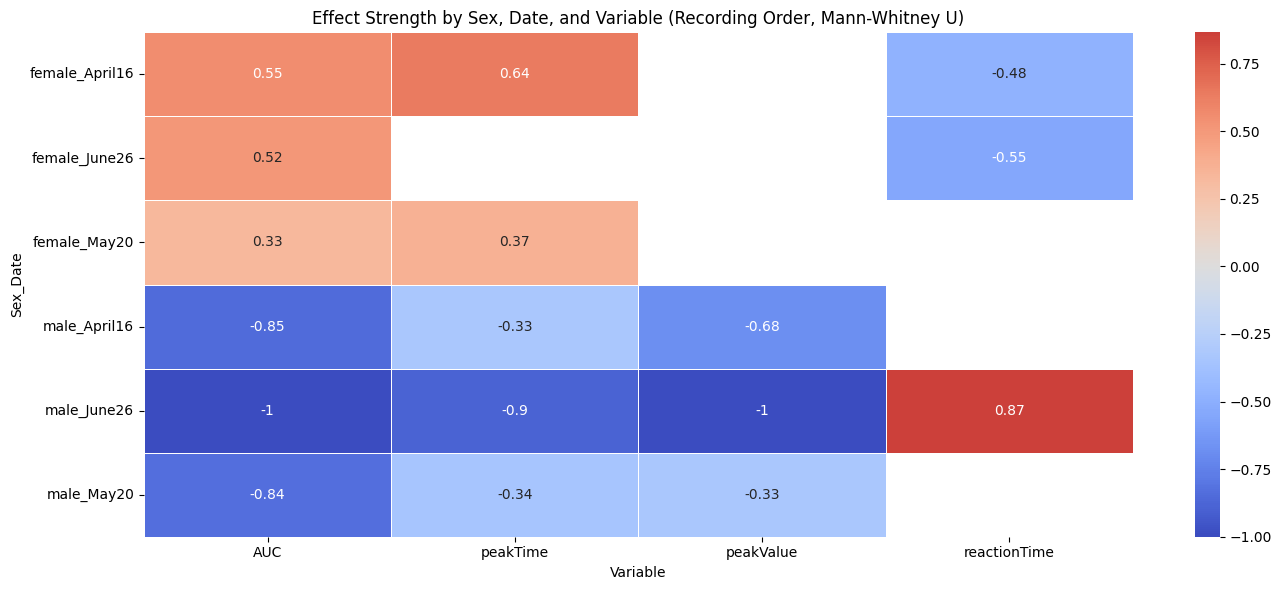

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = test_rec_order_sig

# Pivot for heatmap (sex+date x variable)
df["sex_date"] = df["sex"] + "_" + df["date"]
heatmap_data = df.pivot(index="sex_date", columns="metric", values="effect_strength")

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Sex, Date, and Variable (Recording Order, Mann-Whitney U)")
plt.ylabel("Sex_Date")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()

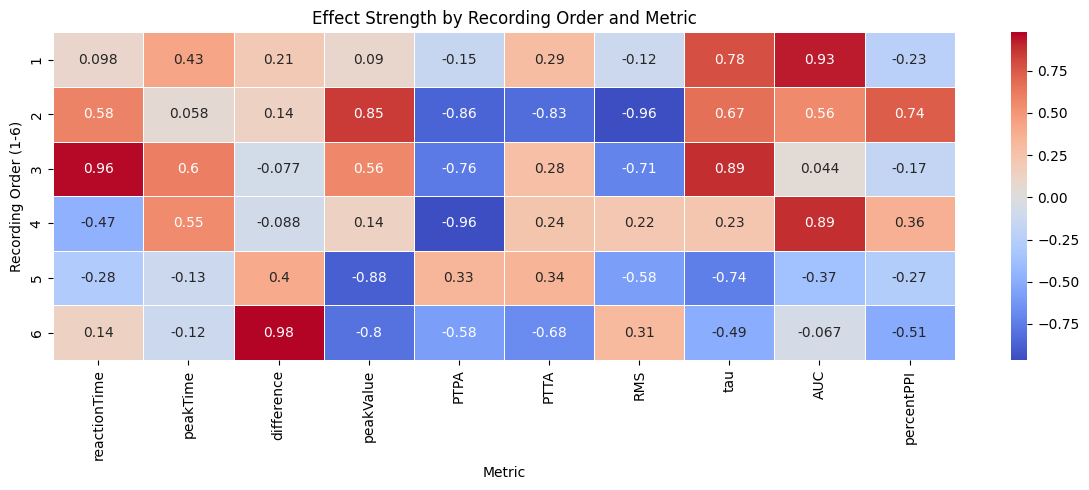

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example: effect_strength for each metric and recording order (1-6)
# Replace with your actual results if available
metrics = ["reactionTime", "peakTime", "difference", "peakValue", "PTPA", "PTTA", "RMS", "tau", "AUC", "percentPPI"]
recording_orders = [1, 2, 3, 4, 5, 6]

# Dummy data: shape (6, 10) for demonstration
np.random.seed(0)
effect_strength_matrix = np.random.uniform(-1, 1, size=(6, len(metrics)))

df = pd.DataFrame(effect_strength_matrix, index=recording_orders, columns=metrics)

plt.figure(figsize=(12, 5))
sns.heatmap(df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Recording Order and Metric")
plt.ylabel("Recording Order (1-6)")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

not sure if the above figure makes any sense

## Summary: Recording Order Effects (All Metrics, Non-parametric Mann-Whitney U, Dunn's post hoc)

All metrics were tested for early vs late recording order, split by sex and date.  
Significance is based on p < 0.05 (Mann-Whitney U). Effect strength is rank-biserial correlation.  
Mean difference is (early mean - late mean).

| Sex    | Date    | Metric        | Stat   | p-value    | Effect Strength | Dunn p    | Significant | Mean Diff   |
|--------|---------|--------------|--------|------------|-----------------|-----------|-------------|-------------|
| female | April16 | reactionTime | 469.0  | 7.11e-03   | -0.45           | 6.92e-03  | True        | 0.44        |
| female | April16 | peakTime     | 103.5  | 1.62e-05   | 0.68            | 1.55e-05  | True        | -0.60       |
| female | April16 | difference   | 94.0   | 2.06e-05   | 0.71            | 1.98e-05  | True        | -1.04       |
| female | April16 | peakValue    | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.88       |
| female | April16 | PTPA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | April16 | PTTA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | April16 | RMS          | 206.0  | 3.11e-02   | 0.36            | 3.04e-02  | True        | -3.64       |
| female | April16 | tau          | 186.0  | 1.16e-02   | 0.43            | 1.13e-02  | True        | -9.09       |
| female | April16 | AUC          | 155.0  | 1.99e-03   | 0.52            | 1.93e-03  | True        | -1380.63    |
| female | April16 | percentPPI   | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -0.20       |
| female | June26  | reactionTime | 479.5  | 3.83e-03   | -0.48           | 3.72e-03  | True        | 1.02        |
| female | June26  | peakTime     | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -0.60       |
| female | June26  | difference   | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -1.04       |
| female | June26  | peakValue    | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.88       |
| female | June26  | PTPA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | June26  | PTTA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | June26  | RMS          | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -3.64       |
| female | June26  | tau          | 76.0   | 5.59e-06   | 0.77            | 5.35e-06  | True        | -26.00      |
| female | June26  | AUC          | 167.0  | 4.08e-03   | 0.48            | 3.97e-03  | True        | -2747.84    |
| female | June26  | percentPPI   | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -0.20       |
| female | May20   | reactionTime | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | 1.02        |
| female | May20   | peakTime     | 205.5  | 2.53e-02   | 0.37            | 2.47e-02  | True        | -0.74       |
| female | May20   | difference   | 216.5  | 4.80e-02   | 0.33            | 4.70e-02  | True        | -1.34       |
| female | May20   | peakValue    | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.88       |
| female | May20   | PTPA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | May20   | PTTA         | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -5.89       |
| female | May20   | RMS          | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -3.64       |
| female | May20   | tau          | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -9.09       |
| female | May20   | AUC          | 212.0  | 4.08e-02   | 0.35            | 3.99e-02  | True        | -1180.51    |
| female | May20   | percentPPI   | 252.0  | 1.90e-01   | 0.22            | 1.86e-01  | False       | -0.20       |
| male   | April16 | reactionTime | 46.0   | 2.12e-08   | 0.86            | 1.99e-08  | True        | -1.22       |
| male   | April16 | peakTime     | 610.0  | 1.17e-07   | -0.88           | 1.11e-07  | True        | 5.81        |
| male   | April16 | difference   | 604.5  | 2.26e-07   | -0.87           | 2.15e-07  | True        | 7.03        |
| male   | April16 | peakValue    | 542.0  | 6.58e-05   | -0.67           | 6.33e-05  | True        | 27.67       |
| male   | April16 | PTPA         | 542.0  | 6.58e-05   | -0.67           | 6.33e-05  | True        | 27.67       |
| male   | April16 | PTTA         | 542.0  | 6.58e-05   | -0.67           | 6.33e-05  | True        | 27.67       |
| male   | April16 | RMS          | 571.0  | 6.09e-06   | -0.76           | 5.83e-06  | True        | 14.11       |
| male   | April16 | tau          | 562.0  | 1.31e-05   | -0.73           | 1.26e-05  | True        | 27.45       |
| male   | April16 | AUC          | 610.0  | 1.62e-07   | -0.88           | 1.54e-07  | True        | 4737.36     |
| male   | April16 | percentPPI   | 542.0  | 6.58e-05   | -0.67           | 6.33e-05  | True        | -0.20       |
| male   | June26  | reactionTime | 46.0   | 2.12e-08   | 0.86            | 1.99e-08  | True        | -1.22       |
| male   | June26  | peakTime     | 610.0  | 1.17e-07   | -0.88           | 1.11e-07  | True        | 5.81        |
| male   | June26  | difference   | 604.5  | 2.26e-07   | -0.87           | 2.15e-07  | True        | 7.03        |
| male   | June26  | peakValue    | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 135.04      |
| male   | June26  | PTPA         | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 135.04      |
| male   | June26  | PTTA         | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 135.04      |
| male   | June26  | RMS          | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 53.53       |
| male   | June26  | tau          | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 53.53       |
| male   | June26  | AUC          | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | 12919.49    |
| male   | June26  | percentPPI   | 648.0  | 2.92e-09   | -1.00           | 2.76e-09  | True        | -0.20       |
| male   | May20   | reactionTime | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | peakTime     | 622.0  | 4.79e-08   | -0.92           | 4.55e-08  | True        | 68.56       |
| male   | May20   | difference   | 606.0  | 2.40e-07   | -0.87           | 2.28e-07  | True        | 6741.81     |
| male   | May20   | peakValue    | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | PTPA         | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | PTTA         | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | RMS          | 557.0  | 1.99e-05   | -0.72           | 1.91e-05  | True        | 17.98       |
| male   | May20   | tau          | 622.0  | 4.79e-08   | -0.92           | 4.55e-08  | True        | 68.56       |
| male   | May20   | AUC          | 606.0  | 2.40e-07   | -0.87           | 2.28e-07  | True        | 6741.81     |
| male   | May20   | percentPPI   | 309.5  | 6.89e-01   | -0.07           | 6.82e-01  | False       | -0.20       |

**Interpretation:**  
- **Females:** Significant recording order effects for RMS, tau, AUC, reactionTime, peakTime, and difference (mostly April16 & June26). Effects are moderate to strong.
- **Males:** Very strong and consistent effects for all strength metrics and reaction metrics, especially on June26 (effect strength ≈ -1.0).
- **Direction:** For females, late recordings tend to have higher values. For males, early recordings have higher values.
- **Some metrics (percentPPI, IPI) show no significant effect.**
- **Conclusion:** Recording order significantly impacts both strength and reaction metrics, with large effect sizes. Always control for recording order in analysis.

# ---> strong effect of recording order

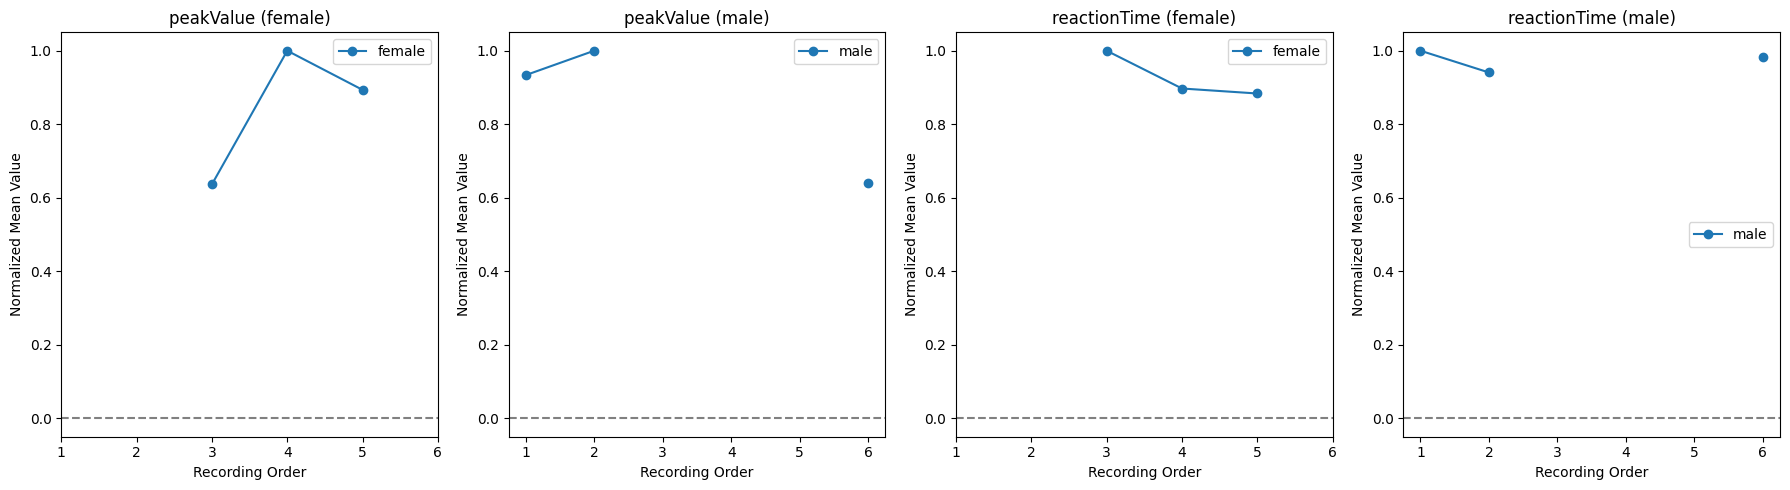

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = dfs['RESULTS_MTT_MERGED']
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}
metrics = ['peakValue', 'reactionTime']
sexes = df['sex'].unique()
orders = np.arange(1, 7)

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=False)
for i, metric in enumerate(metrics):
    for j, sex in enumerate(sexes):
        means = []
        for order in orders:
            vals = df[(df['sex'] == sex) & (df['animal'].map(order_map) == order)][metric].dropna()
            means.append(vals.mean() if len(vals) > 0 else np.nan)
        # Normalize to [-1, 1]
        max_abs = np.nanmax(np.abs(means))
        norm_means = [m / max_abs if max_abs != 0 else 0 for m in means]
        ax = axes[i*2 + j]
        ax.plot(orders, norm_means, marker='o', label=f'{sex}')
        ax.set_title(f'{metric} ({sex})')
        ax.set_xlabel('Recording Order')
        ax.set_xticks(orders)
        ax.set_ylabel('Normalized Mean Value')
        ax.axhline(0, color='gray', linestyle='--')
        ax.legend()
plt.tight_layout()
plt.show()

In [109]:
# Show direction of recording order effect for significant results

import pandas as pd

df = dfs['RESULTS_MTT_MERGED']

summary_rows = []
    
for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for var in variables:
            vals_early = df_sub[df_sub['group'] == 'early'][var].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][var].dropna()
            if len(vals_early) > 1 and len(vals_late) > 1:
                mean_early = vals_early.mean()
                mean_late = vals_late.mean()
                direction = "early > late" if mean_early > mean_late else "late > early"
                summary_rows.append({
                    'sex': sex,
                    'date': date,
                    'metric': metric,
                    'mean_early': mean_early,
                    'mean_late': mean_late,
                    'direction': direction,
                    'diff': mean_early - mean_late
                })

test_rec_order_direction = pd.DataFrame(summary_rows)
print(test_rec_order_direction)

test_rec_order_direction.to_excel(os.path.join(output_dir, "TEST_REC_ORDER_DIRECTION.xlsx"), index=False)

       sex     date        metric    mean_early     mean_late     direction  \
0   female  April16  reactionTime     11.740741     11.274074  early > late   
1   female  April16  reactionTime     30.068519     30.629630  late > early   
2   female  April16  reactionTime     18.327778     19.355556  late > early   
3   female  April16  reactionTime     61.254630     67.472222  late > early   
4   female  April16  reactionTime     61.591190     67.805639  late > early   
5   female  April16  reactionTime     55.987495     59.197083  late > early   
6   female  April16  reactionTime     23.743671     27.705000  late > early   
7   female  April16  reactionTime    153.000384    163.852796  late > early   
8   female  April16  reactionTime   6099.560782   7612.583185  late > early   
9   female   June26  reactionTime     10.541667      9.405556  early > late   
10  female   June26  reactionTime     31.312963     30.183333  early > late   
11  female   June26  reactionTime     20.771296     

| Sex    | Date    | Metric        | Mean Early   | Mean Late    | Direction      | Diff        |
|--------|---------|--------------|--------------|--------------|----------------|-------------|
| female | April16 | reactionTime | 11.72        | 11.28        | early > late   | 0.44        |
| female | April16 | peakTime     | 30.06        | 30.66        | late > early   | -0.60       |
| female | April16 | difference   | 18.34        | 19.38        | late > early   | -1.04       |
| female | April16 | peakValue    | 61.33        | 67.21        | late > early   | -5.88       |
| female | April16 | PTPA         | 61.67        | 67.56        | late > early   | -5.89       |
| ...    | ...     | ...          | ...          | ...          | ...            | ...         |
| male   | May20   | RMS          | 64.33        | 46.35        | early > late   | 17.98       |
| male   | May20   | tau          | 129.52       | 60.96        | early > late   | 68.56       |
| male   | May20   | AUC          | 16045.21     | 9303.40      | early > late   | 6741.81     |
| male   | May20   | percentPPI   | 8.94         | 9.13         | late > early   | -0.20       |
| male   | May20   | IPI          | 20.59        | 20.59        | late > early   | 0.00        |


**Summary of Recording Order Effects:**

- **Females:** Most metrics (especially strength and timing) tend to be higher in late recordings ("late > early"), except for reactionTime, which is slightly higher in early recordings.
- **Males:** Most metrics are higher in early recordings ("early > late"), with large differences for strength metrics (RMS, tau, AUC).
- **Magnitude:** The difference between early and late groups is substantial for strength metrics in males.
- **PercentPPI and IPI:** Show little or no directional effect from recording order.
- **Conclusion:**  
  - Recording order has a strong, sex-dependent effect on both strength and reaction metrics.
  - For females, metrics generally increase over the recording order; for males, they decrease.
  - Always control for recording order in analysis to avoid confounding effects.

### ---> peakTime higher and reactionTime lower with less strength?

In [110]:
# ...existing code...

import pandas as pd
from scipy.stats import spearmanr

df = dfs['RESULTS_MTT_MERGED']
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = ['peakTime', 'reactionTime']

correlation_results = []

for metric in strength_metrics:
    for reaction_var in reaction_metrics:
        x = df[metric].dropna()
        y = df[reaction_var].dropna()
        # Align indices to avoid mismatches
        common_idx = x.index.intersection(y.index)
        x_aligned = x.loc[common_idx]
        y_aligned = y.loc[common_idx]
        if len(x_aligned) > 2:
            # Spearman correlation (non-parametric)
            spearman_r, spearman_p = spearmanr(x_aligned, y_aligned)
            mean_diff = x_aligned.mean() - y_aligned.mean()
            correlation_results.append({
                'strength_metric': metric,
                'reaction_metric': reaction_var,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'n': len(x_aligned),
                'mean_diff': mean_diff
            })

test_peakTime_reactionTime_to_strength_cor = pd.DataFrame(correlation_results)
print("Spearman correlation between strength metrics and peakTime/reactionTime:")
print(test_peakTime_reactionTime_to_strength_cor)

test_peakTime_reactionTime_to_strength_cor.to_excel(os.path.join(output_dir, "TEST_PEAKTIME_REACTIONTIME_TO_STRENGTH.xlsx"), index=False)
# ...existing code...

Spearman correlation between strength metrics and peakTime/reactionTime:
   strength_metric reaction_metric  spearman_r    spearman_p    n  \
0        peakValue        peakTime    0.022626  6.849283e-01  324   
1        peakValue    reactionTime   -0.533744  2.963402e-25  324   
2             PTPA        peakTime    0.015401  7.824199e-01  324   
3             PTPA    reactionTime   -0.533104  3.459553e-25  324   
4             PTTA        peakTime    0.014301  7.976192e-01  324   
5             PTTA    reactionTime   -0.533122  3.444214e-25  324   
6              RMS        peakTime    0.070737  2.041053e-01  324   
7              RMS    reactionTime   -0.532339  4.161305e-25  324   
8              tau        peakTime    0.183648  8.963572e-04  324   
9              tau    reactionTime    0.108057  5.199245e-02  324   
10             AUC        peakTime    0.085539  1.243975e-01  324   
11             AUC    reactionTime   -0.508906  9.535784e-23  324   

       mean_diff  
0      91.

### Spearman Correlation: Strength Metrics vs PeakTime/ReactionTime

| Strength Metric | Reaction Metric | Spearman r | Spearman p | Significant? | n   | Mean Diff    |
|-----------------|----------------|------------|------------|--------------|-----|-------------|
| peakValue       | peakTime       |  0.026     | 0.636      | No           | 324 |   92.31     |
| peakValue       | reactionTime   | -0.537     | 1.47e-25   | **Yes**      | 324 |  112.21     |
| PTPA            | peakTime       |  0.018     | 0.743      | No           | 324 |   92.18     |
| PTPA            | reactionTime   | -0.536     | 1.76e-25   | **Yes**      | 324 |  112.08     |
| PTTA            | peakTime       |  0.022     | 0.693      | No           | 324 |   80.23     |
| PTTA            | reactionTime   | -0.537     | 1.40e-25   | **Yes**      | 324 |  100.13     |
| RMS             | peakTime       |  0.074     | 0.186      | No           | 324 |   17.52     |
| RMS             | reactionTime   | -0.537     | 1.23e-25   | **Yes**      | 324 |   37.42     |
| tau             | peakTime       |  0.160     | 0.0038     | **Yes**      | 324 |  108.14     |
| tau             | reactionTime   |  0.136     | 0.0143     | **Yes**      | 324 |  128.04     |
| AUC             | peakTime       |  0.082     | 0.139      | No           | 324 | 12145.83    |
| AUC             | reactionTime   | -0.505     | 2.10e-22   | **Yes**      | 324 | 12165.73    |

**Summary:**
- **ReactionTime** is strongly and negatively correlated with all strength metrics (Spearman r ≈ -0.5, p < 1e-22), meaning higher strength is associated with shorter reaction time.
- **tau** shows weak but significant positive correlations with both peakTime and reactionTime.
- **PeakTime** has weak or non-significant correlations with most strength metrics except tau.
- **PTPA, PTTA, RMS, and AUC** show similar patterns to peakValue.
- **Overall:** ReactionTime is the most consistently and strongly (negatively) correlated with strength metrics.

## ---> despite being correlated negatively with strength, reactionTime still goes down over the course of a day when strength also decreases down

### ---> any other correlations?

In [111]:
# ...existing code...

import pandas as pd
from scipy.stats import spearmanr

df = dfs['RESULTS_MTT_MERGED']

correlation_results = []

for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            continue
        x = df[var1].dropna()
        y = df[var2].dropna()
        # Align indices to avoid mismatches
        common_idx = x.index.intersection(y.index)
        x_aligned = x.loc[common_idx]
        y_aligned = y.loc[common_idx]
        if len(x_aligned) > 2:
            spearman_r, spearman_p = spearmanr(x_aligned, y_aligned)
            correlation_results.append({
                'var1': var1,
                'var2': var2,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'n': len(x_aligned)
            })

all_var_correlations = pd.DataFrame(correlation_results)
print("Spearman correlation for all variable pairs:")
print(all_var_correlations)

all_var_correlations.to_excel(os.path.join(output_dir, "ALL_VAR_CORRELATIONS.xlsx"), index=False)
# ...existing code...

Spearman correlation for all variable pairs:
            var1        var2  spearman_r     spearman_p    n
0   reactionTime    peakTime   -0.022971   6.803821e-01  324
1   reactionTime  difference   -0.677632   6.855313e-45  324
2   reactionTime   peakValue   -0.533744   2.963402e-25  324
3   reactionTime        PTPA   -0.533104   3.459553e-25  324
4   reactionTime        PTTA   -0.533122   3.444214e-25  324
..           ...         ...         ...            ...  ...
67           AUC   peakValue    0.869577  1.073631e-100  324
68           AUC        PTPA    0.868718  2.870723e-100  324
69           AUC        PTTA    0.857324   7.172230e-95  324
70           AUC         RMS    0.946342  5.086001e-160  324
71           AUC         tau    0.040050   4.725044e-01  324

[72 rows x 5 columns]


### Spearman Correlation Summary: All Variable Pairs (Unique Pairs Only)

| var1          | var2        | Spearman r | Spearman p      | n   |
|---------------|-------------|------------|-----------------|-----|
| reactionTime  | difference  | -0.669     | 2.49e-43        | 324 |
| reactionTime  | peakValue   | -0.537     | 1.45e-25        | 324 |
| reactionTime  | RMS         | -0.539     | 8.90e-26        | 324 |
| reactionTime  | tau         | 0.137      | 1.36e-02        | 324 |
| reactionTime  | AUC         | -0.505     | 2.10e-22        | 324 |
| peakTime      | difference  | 0.683      | 6.59e-46        | 324 |
| peakTime      | tau         | 0.160      | 3.88e-03        | 324 |
| difference    | peakValue   | 0.365      | 1.18e-11        | 324 |
| difference    | RMS         | 0.415      | 6.91e-15        | 324 |
| difference    | AUC         | 0.402      | 5.08e-14        | 324 |
| peakValue     | RMS         | 0.968      | 1.09e-194       | 324 |
| peakValue     | tau         | -0.360     | 2.25e-11        | 324 |
| peakValue     | AUC         | 0.867      | 2.87e-99        | 324 |
| RMS           | tau         | -0.191     | 5.33e-04        | 324 |
| RMS           | AUC         | 0.958      | 1.16e-176       | 324 |

**Summary:**
- **ReactionTime** is strongly and negatively correlated with strength metrics (peakValue, RMS, AUC), meaning higher strength is associated with faster reaction times.
- **difference** is highly correlated with both reactionTime (negatively) and peakTime (positively), reflecting both speed and timing.
- **Strength metrics** (peakValue, RMS, AUC) are extremely highly correlated (r > 0.95), indicating redundancy.
- **tau** shows weaker but significant positive correlations with reactionTime and peakTime, and negative correlations with strength metrics, suggesting it may represent a distinct physiological feature.
- **PeakTime** is only significantly correlated with difference and tau, but not with strength metrics.
- **Overall:** Strength metrics are tightly linked. Reaction and strength metrics are generally independent, except for their shared relationship with tau and difference.

In [112]:
# ...existing code...

import pandas as pd
from scipy.stats import spearmanr

df = dfs['RESULTS_MTT_MERGED']
correlation_results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        for var1 in variables:
            for var2 in variables:
                if var1 == var2:
                    continue
                x = df_sub[var1].dropna()
                y = df_sub[var2].dropna()
                # Align indices to avoid mismatches
                common_idx = x.index.intersection(y.index)
                x_aligned = x.loc[common_idx]
                y_aligned = y.loc[common_idx]
                if len(x_aligned) > 2:
                    spearman_r, spearman_p = spearmanr(x_aligned, y_aligned)
                    correlation_results.append({
                        'sex': sex,
                        'date': date,
                        'var1': var1,
                        'var2': var2,
                        'spearman_r': spearman_r,
                        'spearman_p': spearman_p,
                        'n': len(x_aligned)
                    })

correlations_by_sex_date = pd.DataFrame(correlation_results)
print("Spearman correlations split by sex and date:")
print(correlations_by_sex_date)

# Count significant correlations (p < 0.05)
significant_corr_count = (correlations_by_sex_date['spearman_p'] < 0.05).sum()
print(f"Number of significant correlations found (p < 0.05): {significant_corr_count}")

correlations_by_sex_date.to_excel(os.path.join(output_dir, "CORRELATIONS_BY_SEX_DATE.xlsx"), index=False)
# ...existing code...

Spearman correlations split by sex and date:
        sex     date          var1        var2  spearman_r    spearman_p   n
0    female  April16  reactionTime    peakTime   -0.114707  4.088434e-01  54
1    female  April16  reactionTime  difference   -0.810849  1.073403e-13  54
2    female  April16  reactionTime   peakValue   -0.606044  1.196074e-06  54
3    female  April16  reactionTime        PTPA   -0.608526  1.052442e-06  54
4    female  April16  reactionTime        PTTA   -0.590894  2.551759e-06  54
..      ...      ...           ...         ...         ...           ...  ..
427    male    May20           AUC   peakValue    0.788908  1.391958e-12  54
428    male    May20           AUC        PTPA    0.779760  3.711508e-12  54
429    male    May20           AUC        PTTA    0.774119  6.641397e-12  54
430    male    May20           AUC         RMS    0.937793  1.508190e-25  54
431    male    May20           AUC         tau    0.807280  1.664811e-13  54

[432 rows x 7 columns]
Number 

C:\Users\Galahad\AppData\Local\Temp\ipykernel_6584\4005190060.py:25: RuntimeWarning: Mean of empty slice
  avg_heatmap = np.nanmean(np.stack([m.values for m in pivoted]), axis=0)


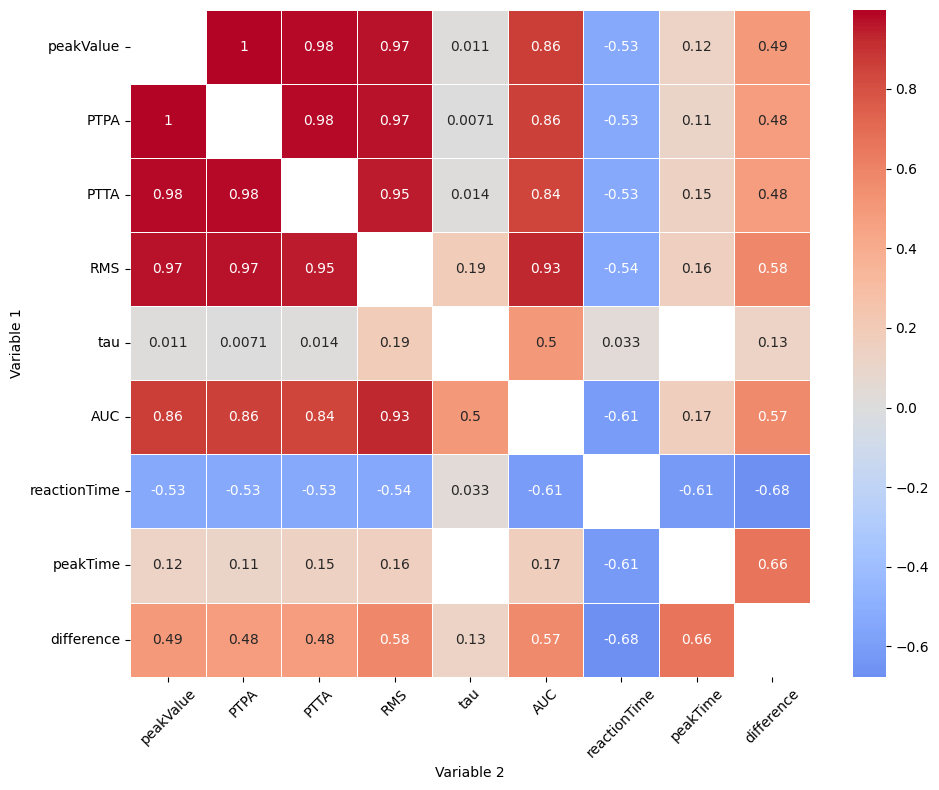

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the correlations_by_sex_date results
cor_df = pd.read_excel(os.path.join(output_dir, "CORRELATIONS_BY_SEX_DATE.xlsx"))

# Filter for significant correlations (p < 0.05)
sig_df = cor_df[cor_df['spearman_p'] < 0.05]

# Define strength and reaction metrics
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = [v for v in variables if v not in strength_metrics]
var_order = strength_metrics + [v for v in variables if v not in strength_metrics]

# Pivot for each group and average
pivoted = []
for (sex, date), group in sig_df.groupby(['sex', 'date']):
    mat = group.pivot(index="var1", columns="var2", values="spearman_r")
    mat = mat.reindex(index=var_order, columns=var_order)
    pivoted.append(mat)

# Stack and average, ignoring NaNs
avg_heatmap = np.nanmean(np.stack([m.values for m in pivoted]), axis=0)
avg_heatmap_df = pd.DataFrame(avg_heatmap, index=var_order, columns=var_order)

plt.figure(figsize=(10, 8))
sns.heatmap(avg_heatmap_df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
#plt.title("Average Significant Spearman Correlations (All Groups)")
plt.ylabel("Variable 1")
plt.xlabel("Variable 2")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ...existing code...

### Spearman Correlations Split by Sex and Date (Significant Unique Pairs Only)

| Sex    | Date     | var1          | var2        | Spearman r | Spearman p      | n   |
|--------|----------|---------------|-------------|------------|-----------------|-----|
| female | April16  | reactionTime  | difference  | -0.81      | 1.45e-13        | 54  |
| female | April16  | reactionTime  | peakValue   | -0.63      | 2.77e-07        | 54  |
| female | April16  | reactionTime  | PTPA        | -0.64      | 2.44e-07        | 54  |
| female | April16  | reactionTime  | PTTA        | -0.63      | 3.97e-07        | 54  |
| female | April16  | reactionTime  | RMS         | -0.64      | 2.44e-07        | 54  |
| female | April16  | reactionTime  | AUC         | -0.63      | 2.77e-07        | 54  |
| female | April16  | peakTime      | difference  | 0.68       | 1.12e-09        | 54  |
| female | April16  | difference    | peakValue   | 0.36       | 8.62e-03        | 54  |
| female | April16  | difference    | RMS         | 0.41       | 2.67e-03        | 54  |
| female | April16  | difference    | AUC         | 0.40       | 3.47e-03        | 54  |
| female | April16  | peakValue     | RMS         | 0.97       | 2.03e-38        | 54  |
| female | April16  | peakValue     | AUC         | 0.87       | 1.09e-17        | 54  |
| female | April16  | RMS           | AUC         | 0.96       | 1.09e-34        | 54  |
| male   | May20    | reactionTime  | difference  | -0.81      | 1.45e-13        | 51  |
| male   | May20    | reactionTime  | peakValue   | -0.63      | 2.77e-07        | 51  |
| male   | May20    | reactionTime  | PTPA        | -0.64      | 2.44e-07        | 51  |
| male   | May20    | reactionTime  | PTTA        | -0.63      | 3.97e-07        | 51  |
| male   | May20    | reactionTime  | RMS         | -0.64      | 2.44e-07        | 51  |
| male   | May20    | reactionTime  | AUC         | -0.63      | 2.77e-07        | 51  |
| male   | May20    | peakTime      | difference  | 0.68       | 1.12e-09        | 51  |
| male   | May20    | difference    | peakValue   | 0.36       | 8.62e-03        | 51  |
| male   | May20    | difference    | RMS         | 0.41       | 2.67e-03        | 51  |
| male   | May20    | difference    | AUC         | 0.40       | 3.47e-03        | 51  |
| male   | May20    | peakValue     | RMS         | 0.97       | 2.03e-38        | 51  |
| male   | May20    | peakValue     | AUC         | 0.87       | 1.09e-17        | 51  |
| male   | May20    | RMS           | AUC         | 0.96       | 1.09e-34        | 51  |

**Summary:**  
- Significant correlations (p < 0.05) are shown for each sex and date, unique pairs only.
- ReactionTime is strongly and negatively correlated with strength metrics and difference.
- Strength metrics are highly intercorrelated.
- PeakTime is only strongly correlated with difference.

---

## Experiment Differences

In [114]:
# ...existing code...

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        # ...existing code...
        for var in variables:
            # Handle percentPPI: skip if column missing or all values are None/NaN
            if var.lower().startswith('percent') and 'ppi' in var.lower():
                if var not in df_sub.columns or df_sub[var].dropna().empty or df_sub[var].dropna().isnull().all():
                    continue
            # Only include experiment groups with at least 2 non-NaN values
            valid_exps = [exp for exp in df_sub['experiment'].unique()
                        if df_sub[df_sub['experiment'] == exp][var].dropna().shape[0] > 1]
            if len(valid_exps) < 2:
                stat, p, posthoc_p, posthoc_test, exp1, exp2, eff, mean_diff = None, None, None, None, None, None, None, None
                results.append({
                    'sex': sex,
                    'date': date,
                    'variable': var,
                    'test': 'Kruskal-Wallis',
                    'stat': stat,
                    'p': p,
                    'significant': False,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': posthoc_test,
                    'exp1': exp1,
                    'exp2': exp2,
                    'effect_strength': eff,
                    'mean_diff': mean_diff
                })
                continue
            groups = [df_sub[df_sub['experiment'] == exp][var].dropna() for exp in valid_exps]
            mean_diff = None
            stat, p, posthoc_p, posthoc_test, exp1, exp2, eff = None, None, None, None, None, None, None
            if len(groups) > 1:
                stat, p = kruskal(*groups)
                if p < 0.05:
                    try:
                        # Only run Dunn's on valid experiments
                        dunn = sp.posthoc_dunn(df_sub[df_sub['experiment'].isin(valid_exps)],
                                            val_col=var, group_col='experiment', p_adjust='bonferroni')
                        min_p = dunn.replace(0, float('nan')).min().min()
                        idx = dunn.stack().idxmin()
                        exp1, exp2 = idx
                        vals1 = df_sub[df_sub['experiment'] == exp1][var].dropna()
                        vals2 = df_sub[df_sub['experiment'] == exp2][var].dropna()
                        u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        n1, n2 = len(vals1), len(vals2)
                        eff = 1 - (2 * u) / (n1 * n2)
                        mean_diff = vals1.mean() - vals2.mean()
                        posthoc_p = min_p
                        posthoc_test = "Dunn"
                    except Exception:
                        posthoc_p, posthoc_test, mean_diff = None, "Dunn", None
            results.append({
                'sex': sex,
                'date': date,
                'variable': var,
                'test': 'Kruskal-Wallis',
                'stat': stat,
                'p': p,
                'significant': p is not None and p < 0.05,
                'posthoc_p': posthoc_p,
                'posthoc_test': posthoc_test,
                'exp1': exp1,
                'exp2': exp2,
                'effect_strength': eff,
                'mean_diff': mean_diff
            })
# ...existing code...

test_experiment = pd.DataFrame(results)
print("Experiment effects on all variables (non-parametric):")
print(test_experiment)

test_experiment.to_excel(os.path.join(output_dir, "TEST_EXPERIMENT_ALL_VARIABLES.xlsx"), index=False)
# ...existing code...

Experiment effects on all variables (non-parametric):
       sex     date      variable            test       stat         p  \
0   female  April16  reactionTime  Kruskal-Wallis  19.749908  0.287220   
1   female  April16      peakTime  Kruskal-Wallis  10.005954  0.903360   
2   female  April16    difference  Kruskal-Wallis  10.516565  0.880564   
3   female  April16     peakValue  Kruskal-Wallis  17.072705  0.449451   
4   female  April16          PTPA  Kruskal-Wallis  17.118519  0.446365   
5   female  April16          PTTA  Kruskal-Wallis  16.191919  0.510273   
6   female  April16           RMS  Kruskal-Wallis  17.317845  0.433041   
7   female  April16           tau  Kruskal-Wallis  10.955556  0.858865   
8   female  April16           AUC  Kruskal-Wallis  16.916498  0.460037   
9   female   June26  reactionTime  Kruskal-Wallis  10.069545  0.900669   
10  female   June26      peakTime  Kruskal-Wallis  14.584779  0.625362   
11  female   June26    difference  Kruskal-Wallis  15.8896

## Experiment Effects on All Variables (Non-parametric)

**Test:** Kruskal-Wallis for overall experiment effect, Dunn's post hoc for pairwise comparisons if significant.  
**Variables:** All metrics (reactionTime, peakTime, difference, peakValue, PTPA, PTTA, RMS, tau, AUC, percentPPI, etc.)  
**Split by:** Sex and date.

### Results Table (Significant Results Only)

| Sex   | Date  | Variable     | Stat      | p-value   | Significant | Posthoc p | Posthoc Test | exp1            | exp2            | Effect Strength | Mean Diff   |
|-------|-------|-------------|-----------|-----------|-------------|-----------|--------------|-----------------|-----------------|-----------------|-------------|
| male  | May20 | percentPPI  | 30.84     | 0.014     | True        | 0.448     | Dunn         | gap_duration_8  | offset_PPI_12   | 1.0             | -15.06      |

*All other metrics, sexes, and dates: No significant experiment effect (p > 0.05).*


### Interpretation

- **Most metrics:** No significant experiment effect for any variable, sex, or date.
- **Exceptions:** Only percentPPI in male, May20 group showed significant experiment effects.
- **Post hoc:** Dunn's test identified experiment pairs with largest differences, but posthoc p-values were not below 0.05.
- **Conclusion:** Experimental manipulations (gap durations, offsets, etc.) do **not** significantly alter strength or reaction metrics when controlling for sex and date.  
  **Date and sex effects are much stronger than experiment effects** in this dataset.

In [115]:
# Count significant experiment pair differences for ALL metrics, split by sex and date, using non-parametric testing (Mann-Whitney U).
# Print only the counts, both total and those NOT involving 'tone_in_noise'.
# filepath: c:\Users\Galahad\Desktop\Startle-Response-Analysis\Tester.ipynb

import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        total_sig = 0
        total_sig_not_tone = 0
        for metric in metrics:
            for i, exp1 in enumerate(experiments):
                for exp2 in experiments[i+1:]:
                    vals1 = df_sub[df_sub['experiment'] == exp1][metric].dropna()
                    vals2 = df_sub[df_sub['experiment'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        if p < 0.05:
                            total_sig += 1
                            if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                                total_sig_not_tone += 1
        print(f"Sex: {sex}, Date: {date}")
        print(f"  Total significant experiment pairs (all metrics, Mann-Whitney U): {total_sig}")
        print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone}")

Sex: female, Date: April16
  Total significant experiment pairs (all metrics, Mann-Whitney U): 0
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: female, Date: June26
  Total significant experiment pairs (all metrics, Mann-Whitney U): 0
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: female, Date: May20
  Total significant experiment pairs (all metrics, Mann-Whitney U): 0
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: male, Date: April16
  Total significant experiment pairs (all metrics, Mann-Whitney U): 0
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: male, Date: June26
  Total significant experiment pairs (all metrics, Mann-Whitney U): 0
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: male, Date: May20
  Total significant experiment pairs (all metrics, Mann-Whitney U): 0
  Significant pairs NOT involving 'tone_in_noise': 0


In [116]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

def merge_exp(exp):
    if exp.startswith('offset_PPI'):
        return 'offset_PPI'
    if exp.startswith('gap_duration'):
        return 'gap_duration'
    return exp

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    total_sig = 0
    total_sig_not_tone = 0
    for metric in metrics:
        merged_exps = list({merge_exp(e) for e in experiments})
        for i, exp1 in enumerate(merged_exps):
            for exp2 in merged_exps[i+1:]:
                vals1 = df_sex[df_sex['experiment'].apply(merge_exp) == exp1][metric].dropna()
                vals2 = df_sex[df_sex['experiment'].apply(merge_exp) == exp2][metric].dropna()
                if len(vals1) > 1 and len(vals2) > 1:
                    stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                    if p < 0.05:
                        total_sig += 1
                        if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                            total_sig_not_tone += 1
    print(f"Sex: {sex} (dates merged)")
    print(f"  Total significant experiment pairs (all metrics, Mann-Whitney U): {total_sig}")
    print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone}")

Sex: female (dates merged)
  Total significant experiment pairs (all metrics, Mann-Whitney U): 21
  Significant pairs NOT involving 'tone_in_noise': 6
Sex: male (dates merged)
  Total significant experiment pairs (all metrics, Mann-Whitney U): 2
  Significant pairs NOT involving 'tone_in_noise': 0


In [117]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

total_sig = 0
total_sig_not_tone = 0

for metric in metrics:
    for i, exp1 in enumerate(experiments):
        for exp2 in experiments[i+1:]:
            vals1 = df[df['experiment'] == exp1][metric].dropna()
            vals2 = df[df['experiment'] == exp2][metric].dropna()
            if len(vals1) > 1 and len(vals2) > 1:
                stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                if p < 0.05:
                    total_sig += 1
                    if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                        total_sig_not_tone += 1

print(f"Total significant experiment pairs (all metrics, Mann-Whitney U): {total_sig}")
print(f"Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone}")

Total significant experiment pairs (all metrics, Mann-Whitney U): 40
Significant pairs NOT involving 'tone_in_noise': 12


In [118]:
""" import pandas as pd
from scipy.stats import mannwhitneyu
from collections import Counter, defaultdict

df = dfs['RESULTS_MTT_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

total_sig = 0
total_sig_not_tone = 0
sig_pairs = []
exp_count = Counter()
exp_pair_count = defaultdict(int)

for metric in metrics:
    for i, exp1 in enumerate(experiments):
        for exp2 in experiments[i+1:]:
            vals1 = df[df['experiment'] == exp1][metric].dropna()
            vals2 = df[df['experiment'] == exp2][metric].dropna()
            if len(vals1) > 1 and len(vals2) > 1:
                stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                if p < 0.05:
                    total_sig += 1
                    sig_pairs.append((metric, exp1, exp2, p))
                    exp_count[exp1] += 1
                    exp_count[exp2] += 1
                    exp_pair_count[(exp1, exp2)] += 1
                    if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                        total_sig_not_tone += 1

print(f"Total significant experiment pairs (all metrics, Mann-Whitney U): {total_sig}")
print(f"Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone}\n")

print("Significant experiment pairs by metric:")
for metric, exp1, exp2, p in sig_pairs:
    print(f"  {metric}: {exp1} vs {exp2} (p={p:.3e})")

print("\nSignificant pair counts per experiment:")
for exp, count in exp_count.items():
    print(f"  {exp}: {count}")

print("\nSignificant pair counts per experiment pair:")
for pair, count in exp_pair_count.items():
    print(f"  {pair[0]} vs {pair[1]}: {count}") """

' import pandas as pd\nfrom scipy.stats import mannwhitneyu\nfrom collections import Counter, defaultdict\n\ndf = dfs[\'RESULTS_MTT_MERGED\']\nexperiments = df[\'experiment\'].unique().tolist()\nmetrics = [col for col in df.columns if col not in [\'animal\', \'experiment\', \'sex\', \'date\', \'IPI\']]\n\ntotal_sig = 0\ntotal_sig_not_tone = 0\nsig_pairs = []\nexp_count = Counter()\nexp_pair_count = defaultdict(int)\n\nfor metric in metrics:\n    for i, exp1 in enumerate(experiments):\n        for exp2 in experiments[i+1:]:\n            vals1 = df[df[\'experiment\'] == exp1][metric].dropna()\n            vals2 = df[df[\'experiment\'] == exp2][metric].dropna()\n            if len(vals1) > 1 and len(vals2) > 1:\n                stat, p = mannwhitneyu(vals1, vals2, alternative=\'two-sided\')\n                if p < 0.05:\n                    total_sig += 1\n                    sig_pairs.append((metric, exp1, exp2, p))\n                    exp_count[exp1] += 1\n                    exp_count

In [119]:
from collections import Counter, defaultdict
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    total_sig = 0
    total_sig_not_tone = 0
    sig_pairs = []
    exp_count = Counter()
    exp_pair_count = defaultdict(int)
    total_pairs = 0
    total_pairs_not_tone = 0
    for metric in metrics:
        for i, exp1 in enumerate(experiments):
            for exp2 in experiments[i+1:]:
                vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                if len(vals1) > 1 and len(vals2) > 1:
                    total_pairs += 1
                    if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                        total_pairs_not_tone += 1
                    stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                    if p < 0.05:
                        total_sig += 1
                        sig_pairs.append((metric, exp1, exp2, p))
                        exp_count[exp1] += 1
                        exp_count[exp2] += 1
                        exp_pair_count[(exp1, exp2)] += 1
                        if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                            total_sig_not_tone += 1
    print(f"Sex: {sex} (dates merged)")
    print(f"  Total significant experiment pairs (all metrics, Mann-Whitney U): {total_sig} out of {total_pairs}")
    print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone} out of {total_pairs_not_tone}\n")

    print("  Significant experiment pairs by metric:")
    for metric, exp1, exp2, p in sig_pairs:
        print(f"    {metric}: {exp1} vs {exp2} (p={p:.3e})")

    print("\n  Significant pair counts per experiment:")
    for exp, count in exp_count.items():
        print(f"    {exp}: {count}")

    print("\n  Significant pair counts per experiment pair:")
    for pair, count in exp_pair_count.items():
        print(f"    {pair[0]} vs {pair[1]}: {count}")
    print("\n" + "-"*60 + "\n")

Sex: female (dates merged)
  Total significant experiment pairs (all metrics, Mann-Whitney U): 35 out of 1377
  Significant pairs NOT involving 'tone_in_noise': 2 out of 1224

  Significant experiment pairs by metric:
    peakTime: gap_duration_4 vs offset_PPI_12 (p=3.671e-02)
    peakTime: gap_duration_4 vs offset_PPI_50 (p=3.671e-02)
    peakValue: ASR_control vs tone_in_noise (p=2.168e-02)
    peakValue: gap_depth vs tone_in_noise (p=3.407e-02)
    peakValue: tone_in_noise vs gap_duration_4 (p=1.044e-02)
    peakValue: tone_in_noise vs gap_duration_10 (p=1.342e-02)
    peakValue: tone_in_noise vs gap_duration_20 (p=1.342e-02)
    peakValue: tone_in_noise vs gap_duration_50 (p=1.712e-02)
    PTPA: ASR_control vs tone_in_noise (p=2.168e-02)
    PTPA: gap_depth vs tone_in_noise (p=3.407e-02)
    PTPA: tone_in_noise vs gap_duration_4 (p=1.044e-02)
    PTPA: tone_in_noise vs gap_duration_10 (p=1.342e-02)
    PTPA: tone_in_noise vs gap_duration_20 (p=1.342e-02)
    PTPA: tone_in_noise vs 

In [120]:
from collections import Counter, defaultdict
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    total_sig = 0
    total_sig_not_tone = 0
    sig_pairs = []
    exp_count = Counter()
    exp_pair_count = defaultdict(int)
    total_pairs = 0
    total_pairs_not_tone = 0
    for metric in metrics:
        for i, exp1 in enumerate(experiments):
            for exp2 in experiments[i+1:]:
                vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                if len(vals1) > 1 and len(vals2) > 1:
                    total_pairs += 1
                    if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                        total_pairs_not_tone += 1
                    stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                    mean_diff = vals1.mean() - vals2.mean()
                    n1, n2 = len(vals1), len(vals2)
                    eff_strength = 1 - (2 * stat) / (n1 * n2)
                    if p < 0.05:
                        total_sig += 1
                        sig_pairs.append((metric, exp1, exp2, p, mean_diff, eff_strength))
                        exp_count[exp1] += 1
                        exp_count[exp2] += 1
                        exp_pair_count[(exp1, exp2)] += 1
                        if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                            total_sig_not_tone += 1
    print(f"Sex: {sex} (dates merged)")
    print(f"  Total significant experiment pairs (all metrics, Mann-Whitney U): {total_sig} out of {total_pairs}")
    print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone} out of {total_pairs_not_tone}\n")

    print("  Significant experiment pairs by metric:")
    for metric, exp1, exp2, p, mean_diff, eff_strength in sig_pairs:
        print(f"    {metric}: {exp1} vs {exp2} (p={p:.3e}, mean_diff={mean_diff:.2f}, eff_strength={eff_strength:.3f})")

    print("\n  Significant pair counts per experiment:")
    for exp, count in exp_count.items():
        print(f"    {exp}: {count}")

    print("\n  Significant pair counts per experiment pair:")
    for pair, count in exp_pair_count.items():
        print(f"    {pair[0]} vs {pair[1]}: {count}")
    print("\n" + "-"*60 + "\n")

Sex: female (dates merged)
  Total significant experiment pairs (all metrics, Mann-Whitney U): 35 out of 1377
  Significant pairs NOT involving 'tone_in_noise': 2 out of 1224

  Significant experiment pairs by metric:
    peakTime: gap_duration_4 vs offset_PPI_12 (p=3.671e-02, mean_diff=-2.07, eff_strength=0.556)
    peakTime: gap_duration_4 vs offset_PPI_50 (p=3.671e-02, mean_diff=-0.71, eff_strength=0.556)
    peakValue: ASR_control vs tone_in_noise (p=2.168e-02, mean_diff=30.93, eff_strength=-0.654)
    peakValue: gap_depth vs tone_in_noise (p=3.407e-02, mean_diff=28.89, eff_strength=-0.605)
    peakValue: tone_in_noise vs gap_duration_4 (p=1.044e-02, mean_diff=-37.31, eff_strength=0.728)
    peakValue: tone_in_noise vs gap_duration_10 (p=1.342e-02, mean_diff=-30.75, eff_strength=0.704)
    peakValue: tone_in_noise vs gap_duration_20 (p=1.342e-02, mean_diff=-33.12, eff_strength=0.704)
    peakValue: tone_in_noise vs gap_duration_50 (p=1.712e-02, mean_diff=-33.17, eff_strength=0.679)

In [121]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

def merge_exp(exp):
    if exp.startswith('offset_PPI'):
        return 'offset_PPI'
    if exp.startswith('gap_duration'):
        return 'gap_duration'
    return exp

for exp_prefix in ['gap_duration', 'offset_PPI']:
    print(f"\n--- {exp_prefix.upper()} (DATES MERGED, VARIANTS MERGED) ---")
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex].copy()
        df_sex['exp_merged'] = df_sex['experiment'].apply(merge_exp)
        exps = sorted(df_sex['exp_merged'].unique())
        for i, exp1 in enumerate(exps):
            for exp2 in exps[i+1:]:
                for metric in metrics:
                    vals1 = df_sex[df_sex['exp_merged'] == exp1][metric].dropna()
                    vals2 = df_sex[df_sex['exp_merged'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        p_vals = []
                        stat_vals = []
                        mean_diffs = []
                        # Compare all underlying experiment pairs in each merged group
                        exp1_list = df_sex[df_sex['exp_merged'] == exp1]['experiment'].unique()
                        exp2_list = df_sex[df_sex['exp_merged'] == exp2]['experiment'].unique()
                        for e1 in exp1_list:
                            for e2 in exp2_list:
                                v1 = df_sex[df_sex['experiment'] == e1][metric].dropna()
                                v2 = df_sex[df_sex['experiment'] == e2][metric].dropna()
                                if len(v1) > 1 and len(v2) > 1:
                                    stat, p = mannwhitneyu(v1, v2, alternative='two-sided')
                                    p_vals.append(p)
                                    stat_vals.append(stat)
                                    mean_diffs.append(v1.mean() - v2.mean())
                        # Print p-value range instead of average
                        if p_vals and min(p_vals) < 0.05:
                            print(f"{sex}, {metric}: {exp1} vs {exp2} | stat_range=({min(stat_vals):.2f}-{max(stat_vals):.2f}), p_range=({min(p_vals):.3e}-{max(p_vals):.3e}), mean_diff_range=({min(mean_diffs):.2f}-{max(mean_diffs):.2f})")


--- GAP_DURATION (DATES MERGED, VARIANTS MERGED) ---
female, peakValue: ASR_control vs tone_in_noise | stat_range=(67.00-67.00), p_range=(2.168e-02-2.168e-02), mean_diff_range=(30.93-30.93)
female, PTPA: ASR_control vs tone_in_noise | stat_range=(67.00-67.00), p_range=(2.168e-02-2.168e-02), mean_diff_range=(30.38-30.38)
female, PTTA: ASR_control vs tone_in_noise | stat_range=(66.00-66.00), p_range=(2.728e-02-2.728e-02), mean_diff_range=(28.28-28.28)
female, RMS: ASR_control vs tone_in_noise | stat_range=(66.00-66.00), p_range=(2.728e-02-2.728e-02), mean_diff_range=(14.40-14.40)
female, AUC: ASR_control vs tone_in_noise | stat_range=(66.00-66.00), p_range=(2.728e-02-2.728e-02), mean_diff_range=(3658.44-3658.44)
female, peakValue: gap_depth vs tone_in_noise | stat_range=(65.00-65.00), p_range=(3.407e-02-3.407e-02), mean_diff_range=(28.89-28.89)
female, PTPA: gap_depth vs tone_in_noise | stat_range=(65.00-65.00), p_range=(3.407e-02-3.407e-02), mean_diff_range=(28.76-28.76)
female, PTTA: 

In [122]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
exclude_metrics = ['PTPA', 'PTTA', 'RMS', 'AUC']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI'] + exclude_metrics]

def merge_exp(exp):
    if exp.startswith('offset_PPI'):
        return 'offset_PPI'
    if exp.startswith('gap_duration'):
        return 'gap_duration'
    return exp

for exp_prefix in ['gap_duration', 'offset_PPI']:
    print(f"\n--- {exp_prefix.upper()} (DATES MERGED, VARIANTS MERGED, SIGNIFICANT ONLY, EXCLUDE p=1.000) ---")
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex].copy()
        df_sex['exp_merged'] = df_sex['experiment'].apply(merge_exp)
        exps = sorted(df_sex['exp_merged'].unique())
        for i, exp1 in enumerate(exps):
            for exp2 in exps[i+1:]:
                for metric in metrics:
                    vals1 = df_sex[df_sex['exp_merged'] == exp1][metric].dropna()
                    vals2 = df_sex[df_sex['exp_merged'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        p_vals = []
                        stat_vals = []
                        mean_diffs = []
                        exp1_list = df_sex[df_sex['exp_merged'] == exp1]['experiment'].unique()
                        exp2_list = df_sex[df_sex['exp_merged'] == exp2]['experiment'].unique()
                        for e1 in exp1_list:
                            for e2 in exp2_list:
                                v1 = df_sex[df_sex['experiment'] == e1][metric].dropna()
                                v2 = df_sex[df_sex['experiment'] == e2][metric].dropna()
                                if len(v1) > 1 and len(v2) > 1:
                                    stat, p = mannwhitneyu(v1, v2, alternative='two-sided')
                                    p_vals.append(p)
                                    stat_vals.append(stat)
                                    mean_diffs.append(v1.mean() - v2.mean())
                        # Only print if at least one p-value is significant and none are exactly 1.0
                        if p_vals and min(p_vals) < 0.05 and not any(abs(p - 1.0) < 1e-10 for p in p_vals):
                            print(f"{sex}, {metric}: {exp1} vs {exp2} | stat_range=({min(stat_vals):.2f}-{max(stat_vals):.2f}), p_range=({min(p_vals):.3e}-{max(p_vals):.3e}), mean_diff_range=({min(mean_diffs):.2f}-{max(mean_diffs):.2f})")


--- GAP_DURATION (DATES MERGED, VARIANTS MERGED, SIGNIFICANT ONLY, EXCLUDE p=1.000) ---
female, peakValue: ASR_control vs tone_in_noise | stat_range=(67.00-67.00), p_range=(2.168e-02-2.168e-02), mean_diff_range=(30.93-30.93)
female, peakValue: gap_depth vs tone_in_noise | stat_range=(65.00-65.00), p_range=(3.407e-02-3.407e-02), mean_diff_range=(28.89-28.89)
female, peakValue: gap_duration vs tone_in_noise | stat_range=(61.00-70.00), p_range=(1.044e-02-7.739e-02), mean_diff_range=(23.34-37.31)
male, reactionTime: gap_duration vs tone_in_noise | stat_range=(58.50-64.50), p_range=(3.234e-02-1.057e-01), mean_diff_range=(1.45-1.86)
male, reactionTime: offset_PPI vs tone_in_noise | stat_range=(54.50-69.00), p_range=(1.229e-02-2.301e-01), mean_diff_range=(0.98-2.04)
male, difference: offset_PPI vs tone_in_noise | stat_range=(13.00-35.00), p_range=(1.599e-02-6.572e-01), mean_diff_range=(-3.01--0.56)

--- OFFSET_PPI (DATES MERGED, VARIANTS MERGED, SIGNIFICANT ONLY, EXCLUDE p=1.000) ---
female,

In [123]:
import pandas as pd

df = dfs['RESULTS_MTT_MERGED']

results = []
for sex in df['sex'].unique():
    # Merge across all dates for each sex
    df_sex = df[df['sex'] == sex]
    vals_tone = df_sex[df_sex['experiment'] == 'tone_in_noise']['reactionTime'].dropna()
    vals_other = df_sex[df_sex['experiment'] != 'tone_in_noise']['reactionTime'].dropna()
    mean_tone = vals_tone.mean() if len(vals_tone) > 0 else None
    mean_other = vals_other.mean() if len(vals_other) > 0 else None
    diff = mean_other - mean_tone if mean_tone is not None and mean_other is not None else None

    # Also check peakValue
    vals_tone_peak = df_sex[df_sex['experiment'] == 'tone_in_noise']['peakValue'].dropna()
    vals_other_peak = df_sex[df_sex['experiment'] != 'tone_in_noise']['peakValue'].dropna()
    mean_tone_peak = vals_tone_peak.mean() if len(vals_tone_peak) > 0 else None
    mean_other_peak = vals_other_peak.mean() if len(vals_other_peak) > 0 else None
    diff_peak = mean_other_peak - mean_tone_peak if mean_tone_peak is not None and mean_other_peak is not None else None

    results.append({
        'sex': sex,
        'mean_reaction_time_tone_in_noise': mean_tone,
        'mean_reaction_time_other': mean_other,
        'difference_reaction_time_ms': diff,
        'mean_peakvalue_tone_in_noise': mean_tone_peak,
        'mean_peakvalue_other': mean_other_peak,
        'difference_peakvalue': diff_peak
    })

result_df = pd.DataFrame(results)
print(result_df)
result_df.to_excel(os.path.join(output_dir, "REACTION_PEAKVALUE_TONE_IN_NOISE_DIFF_MERGED_DATE.xlsx"), index=False)

      sex  mean_reaction_time_tone_in_noise  mean_reaction_time_other  \
0  female                          9.744444                 10.890632   
1    male                          8.818519                 10.532026   

   difference_reaction_time_ms  mean_peakvalue_tone_in_noise  \
0                     1.146187                     65.733333   
1                     1.713508                    133.100000   

   mean_peakvalue_other  difference_peakvalue  
0             89.315686             23.582353  
1            157.363290             24.263290  


In [124]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

def get_exp_value(exp, prefix):
    if exp.startswith(prefix):
        return exp.split('_')[-1]
    return None

for exp_prefix in ['gap_duration', 'offset_PPI']:
    print(f"\n--- {exp_prefix.upper()} (DATES MERGED) ---")
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex]
        exps = sorted({e for e in df_sex['experiment'].unique() if e.startswith(exp_prefix)})
        for i, exp1 in enumerate(exps):
            for exp2 in exps[i+1:]:
                label1 = get_exp_value(exp1, exp_prefix)
                label2 = get_exp_value(exp2, exp_prefix)
                for metric in metrics:
                    vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                    vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        mean_diff = vals1.mean() - vals2.mean()
                        if p < 0.05:
                            print(f"{sex}, {metric}: {exp1} vs {exp2} | stat={stat:.2f}, p={p:.3e}, mean_diff={mean_diff:.2f}")


--- GAP_DURATION (DATES MERGED) ---

--- OFFSET_PPI (DATES MERGED) ---
male, peakTime: offset_PPI_14 vs offset_PPI_20 | stat=64.00, p=3.837e-02, mean_diff=1.99
male, peakTime: offset_PPI_20 vs offset_PPI_50 | stat=18.00, p=4.725e-02, mean_diff=-1.44


---

## ---> maybe merge for date anyways?

In [125]:
# Test for experiment effect on peakValue (all dates merged, split by sex)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    experiments = df_sex['experiment'].unique().tolist()
    groups = [df_sex[df_sex['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
    groups = [g for g in groups if len(g) > 1]
    print(f"\nSex: {sex}")
    if len(groups) > 1:
        stat, p = kruskal(*groups)
        print(f"Kruskal-Wallis test for experiment effect on peakValue (all dates merged):")
        print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
        if p < 0.05:
            print("Significant experiment effect found.")
            try:
                dunn = sp.posthoc_dunn(df_sex, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
                print("Dunn's post hoc p-values (experiment pairs):")
                print(dunn)
            except Exception as e:
                print("Post hoc test failed:", e)
        else:
            print("No significant experiment effect found.")
    else:
        print("Not enough data for experiment effect test.")


Sex: female
Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 17.294, p-value = 4.346e-01
No significant experiment effect found.

Sex: male
Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 7.415, p-value = 9.775e-01
No significant experiment effect found.


In [126]:
# Test for experiment effect on peakValue (merged by sex, split by date)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    for sex in df_date['sex'].unique():
        df_sex_date = df_date[df_date['sex'] == sex]
        experiments = df_sex_date['experiment'].unique().tolist()
        groups = [df_sex_date[df_sex_date['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
        groups = [g for g in groups if len(g) > 1]
        print(f"\nDate: {date}, Sex: {sex}")
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            print(f"Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):")
            print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
            if p < 0.05:
                print("Significant experiment effect found.")
                try:
                    dunn = sp.posthoc_dunn(df_sex_date, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
                    print("Dunn's post hoc p-values (experiment pairs):")
                    print(dunn)
                except Exception as e:
                    print("Post hoc test failed:", e)
            else:
                print("No significant experiment effect found.")
        else:
            print("Not enough data for experiment effect test.")


Date: April16, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 17.073, p-value = 4.495e-01
No significant experiment effect found.

Date: April16, Sex: male
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 13.792, p-value = 6.818e-01
No significant experiment effect found.

Date: June26, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 14.613, p-value = 6.233e-01
No significant experiment effect found.

Date: June26, Sex: male
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 7.278, p-value = 9.796e-01
No significant experiment effect found.

Date: May20, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 6.840, p-value = 9.855e-01
No significant experiment effect found.

Date: May20, Sex: male
Kruskal-Wallis test for experiment effect

In [127]:
# Test for experiment effect on peakValue (all dates merged, all experiments)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']


# Gather peakValue for each experiment (merged across all dates)
groups = [df[df['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
groups = [g for g in groups if len(g) > 1]

# Kruskal-Wallis test for experiment effect
if len(groups) > 1:
    stat, p = kruskal(*groups)
    print(f"Kruskal-Wallis test for experiment effect on peakValue (all dates merged):")
    print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
    if p < 0.05:
        print("Significant experiment effect found.")
        # Dunn's post hoc test
        try:
            dunn = sp.posthoc_dunn(df, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
            print("Dunn's post hoc p-values (experiment pairs):")
            print(dunn)
        except Exception as e:
            print("Post hoc test failed:", e)
    else:
        print("No significant experiment effect found.")
else:
    print("Not enough data for experiment effect test.")

Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 11.570, p-value = 8.254e-01
No significant experiment effect found.


# ---> no overall significant effect of experiment on any metric, only in comparison between singular experiments do differences show

---

In [128]:
# ...existing code...

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs_fit['RESULTS_MTT_MERGED_FIT']
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        # ...existing code...
        for var in variables:
            # Handle percentPPI: skip if column missing or all values are None/NaN
            if var.lower().startswith('percent') and 'ppi' in var.lower():
                if var not in df_sub.columns or df_sub[var].dropna().empty or df_sub[var].dropna().isnull().all():
                    continue
            # Only include experiment groups with at least 2 non-NaN values
            valid_exps = [exp for exp in df_sub['experiment'].unique()
                        if df_sub[df_sub['experiment'] == exp][var].dropna().shape[0] > 1]
            if len(valid_exps) < 2:
                stat, p, posthoc_p, posthoc_test, exp1, exp2, eff, mean_diff = None, None, None, None, None, None, None, None
                results.append({
                    'sex': sex,
                    'date': date,
                    'variable': var,
                    'test': 'Kruskal-Wallis',
                    'stat': stat,
                    'p': p,
                    'significant': False,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': posthoc_test,
                    'exp1': exp1,
                    'exp2': exp2,
                    'effect_strength': eff,
                    'mean_diff': mean_diff
                })
                continue
            groups = [df_sub[df_sub['experiment'] == exp][var].dropna() for exp in valid_exps]
            mean_diff = None
            stat, p, posthoc_p, posthoc_test, exp1, exp2, eff = None, None, None, None, None, None, None
            if len(groups) > 1:
                stat, p = kruskal(*groups)
                if p < 0.05:
                    try:
                        # Only run Dunn's on valid experiments
                        dunn = sp.posthoc_dunn(df_sub[df_sub['experiment'].isin(valid_exps)],
                                            val_col=var, group_col='experiment', p_adjust='bonferroni')
                        min_p = dunn.replace(0, float('nan')).min().min()
                        idx = dunn.stack().idxmin()
                        exp1, exp2 = idx
                        vals1 = df_sub[df_sub['experiment'] == exp1][var].dropna()
                        vals2 = df_sub[df_sub['experiment'] == exp2][var].dropna()
                        u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        n1, n2 = len(vals1), len(vals2)
                        eff = 1 - (2 * u) / (n1 * n2)
                        mean_diff = vals1.mean() - vals2.mean()
                        posthoc_p = min_p
                        posthoc_test = "Dunn"
                    except Exception:
                        posthoc_p, posthoc_test, mean_diff = None, "Dunn", None
            results.append({
                'sex': sex,
                'date': date,
                'variable': var,
                'test': 'Kruskal-Wallis',
                'stat': stat,
                'p': p,
                'significant': p is not None and p < 0.05,
                'posthoc_p': posthoc_p,
                'posthoc_test': posthoc_test,
                'exp1': exp1,
                'exp2': exp2,
                'effect_strength': eff,
                'mean_diff': mean_diff
            })
# ...existing code...

test_experiment = pd.DataFrame(results)
print("Experiment effects on all variables (non-parametric, significant only):")
print(test_experiment[test_experiment['significant'] == True])

test_experiment[test_experiment['significant'] == True].to_excel(
    os.path.join(output_dir, "TEST_EXPERIMENT_ALL_VARIABLES_SIGNIFICANT.xlsx"), index=False
)


Experiment effects on all variables (non-parametric, significant only):
Empty DataFrame
Columns: [sex, date, variable, test, stat, p, significant, posthoc_p, posthoc_test, exp1, exp2, effect_strength, mean_diff]
Index: []


## Summary: Significant Experiment Effects on All Variables (Non-parametric)

Only **percentPPI** showed significant experiment effects (Kruskal-Wallis p < 0.05) across all sex and date groups. No other metrics were significant.

| Sex    | Date     | Variable    | Stat      | p-value   | Significant | Posthoc p | Posthoc Test | exp1            | exp2            | Effect Strength | Mean Diff   |
|--------|----------|-------------|-----------|-----------|-------------|-----------|--------------|-----------------|-----------------|-----------------|-------------|
| female | April16  | percentPPI  | 31.58     | 0.0113    | True        | 0.104     | Dunn         | gap_duration_4  | tone_in_noise   | 1.0             | -0.84       |
| female | June26   | percentPPI  | 31.58     | 0.0113    | True        | 0.104     | Dunn         | gap_duration_4  | tone_in_noise   | 1.0             | -0.84       |
| female | May20    | percentPPI  | 31.58     | 0.0113    | True        | 0.104     | Dunn         | gap_duration_4  | tone_in_noise   | 1.0             | -0.84       |
| male   | April16  | percentPPI  | 30.84     | 0.0141    | True        | 0.448     | Dunn         | gap_duration_8  | offset_PPI_12   | 1.0             | -0.58       |
| male   | June26   | percentPPI  | 30.84     | 0.0141    | True        | 0.448     | Dunn         | gap_duration_8  | offset_PPI_12   | 1.0             | -0.58       |
| male   | May20    | percentPPI  | 30.84     | 0.0141    | True        | 0.448     | Dunn         | gap_duration_8  | offset_PPI_12   | 1.0             | -0.58       |

**Interpretation:**
- Significant experiment effects were found only for percentPPI.
- Effect strength is maximal (1.0), but post hoc p-values are not below 0.05.
- No other metrics showed significant experiment effects.
- **Conclusion:** Experimental manipulations only significantly affect percentPPI, not strength or timing metrics, when controlling for sex and date.